# CNN with LoTSS

In [8]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np
import time

In [2]:
torch.cuda.current_device()

0

In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.savefig('average_pool_loss.png', dpi=fig_1.dpi)
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.savefig('average_pool_acc.png', dpi=fig_2.dpi)

    plt.show()

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, dropout_rate, num_output_classes, num_filters, num_layers, use_bias=False):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        self.dropout_rate = dropout_rate
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape))  # create dummy inputs to be used to infer shapes of layers

        filter_lookup = [32, 64, 194]
        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=filter_lookup[i], padding=1,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.dropout2d(out, p=self.dropout_rate)
            out = F.relu(out)  # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution':  # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # use strided conv to get an outputs
                out = F.relu(out)  # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output
            elif self.dim_reduction_type == 'conv_layers':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_conv_layers_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=(self.red_kernel_size + (i+1)*(self.red_kernel_size-1)),
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=1)
                out = self.layer_dict['dim_reduction_conv_layers_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)
        out = out.view(out.shape[0], -1)
        self.fc_layer = nn.Linear(in_features=out.shape[1],
                                  out_features=194,
                                  bias=self.use_bias)
        out = self.fc_layer(out)
        out = F.dropout(out, p=self.dropout_rate)
        out = F.relu(out)
        # if out.shape[-1] != 2:
        #     out = F.adaptive_avg_pool2d(out, 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        # print('shape before final linear layer', out.shape)
        # out = out.view(out.shape[0], -1)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        out = F.softmax(out)
        return out

    def forward(self, x, training=True):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers):  # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.dropout(out, p=self.dropout_rate, training=training)
            out = F.relu(out)  # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # pass previous outputs through a strided convolution indexed i
                out = F.relu(out)  # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'conv_layers':
                out = self.layer_dict['dim_reduction_conv_layers_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        # if out.shape[-1] != 2:
        #     out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.fc_layer(out)
        out = F.dropout(out, p=self.dropout_rate, training=training)
        out = F.relu(out)
        out = self.logit_linear_layer(out)  # pass through a linear layer to get logits/preds
        out = F.softmax(out)
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logit_linear_layer.reset_parameters()
        self.fc_layer.reset_parameters()

In [7]:
from mlp.pytorch_experiment_scripts.storage_utils import save_to_stats_pkl_file, load_from_stats_pkl_file, \
    save_statistics, load_statistics


class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, learning_rate, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu:  # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda')  # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # sets the main GPU to be the one at index 0 (on multi gpu machines you can choose which one you want to use by using the relevant GPU ID)
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu')  # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device)  # sends the model from the cpu to the gpu
        self.model.reset_parameters()  # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        # self.optimizer = optim.Adam(self.parameters(), amsgrad=False, lr=learning_rate,
        #                             weight_decay=weight_decay_coefficient)
        self.optimizer = optim.RMSprop(self.parameters(), lr=learning_rate, alpha=0.9)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.

        if not os.path.exists(self.experiment_folder):  # If experiment directory does not exist
            os.mkdir(self.experiment_folder)  # create the experiment directory
            os.mkdir(self.experiment_logs)  # create the experiment log directory
            os.mkdir(self.experiment_saved_models)  # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device)  # send the loss computation to the GPU

        if continue_from_epoch != -1:  # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch)  # reload existing model from epoch and return best val model index
            # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train()  # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1)  # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(
            device=self.device)  # send data to device as torch tensors
        out = self.model.forward(x, training=True)  # forward the data in the model
        loss = F.cross_entropy(input=out, target=y)  # compute loss

        self.optimizer.zero_grad()  # set all weight grads from previous training iters to 0
        loss.backward()  # backpropagate to compute gradients for current iter loss

        self.optimizer.step()  # update network parameters
        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval()  # sets the system to validation mode
        y = np.argmax(y, axis=1)  # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(
            device=self.device)  # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x, training=False)  # forward the data in the model
        loss = F.cross_entropy(out, y)  # compute loss
        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.
        """
        state = dict()
        state['network'] = self.state_dict()  # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx  # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc  # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(
            model_idx))))  # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [],
                        "val_loss": []}  # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train:  # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data):  # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y)  # take a training iter step
                    current_epoch_losses["train_loss"].append(loss)  # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy)  # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val:  # create a progress bar for validation
                for x, y in self.val_data:  # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y)  # run a validation iter
                    current_epoch_losses["val_loss"].append(loss)  # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy)  # add current iter acc to val acc lst.
                    pbar_val.update(1)  # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))
            val_mean_accuracy = np.mean(current_epoch_losses['val_acc'])
            if val_mean_accuracy > self.best_val_model_acc:  # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = val_mean_accuracy  # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx  # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(
                    value))  # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i)  # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(
                ["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time  # calculate time taken for epoch
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            self.save_model(model_save_dir=self.experiment_saved_models,
                            # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx,
                        # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []}  # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test:  # ini a progress bar
            for x, y in self.test_data:  # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x,
                                                          y=y)  # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss)  # save test loss
                current_epoch_losses["test_acc"].append(accuracy)  # save test accuracy
                pbar_test.update(1)  # update progress bar status
                pbar_test.set_description(
                    "loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in
                       current_epoch_losses.items()}  # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv',
                        # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses

## Experiment 1 LA - average pool

In [9]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 3
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'average_pool'
num_epochs = 50
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

In [21]:
custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])
use GPU


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6924, accuracy: 0.5156: 100%|██████████| 14/14 [00:00<00:00, 35.76it/s]


Epoch 0: train_acc_0.5347_train_loss_0.6927_val_acc_0.5491_val_loss_0.6913 epoch time 4.1373 seconds


loss: 0.6845, accuracy: 0.4922:  20%|██        | 2/10 [00:00<00:00, 14.33it/s]

Epoch 1: train_acc_0.5641_train_loss_0.6886_val_acc_0.5502_val_loss_0.6853 epoch time 1.4804 seconds


loss: 0.6768, accuracy: 0.5234:  10%|█         | 1/10 [00:00<00:00, 10.32it/s]

Epoch 2: train_acc_0.5391_train_loss_0.6824_val_acc_0.5497_val_loss_0.6776 epoch time 1.5378 seconds


loss: 0.6773, accuracy: 0.4922:  20%|██        | 2/10 [00:00<00:00, 15.63it/s]

Epoch 3: train_acc_0.5398_train_loss_0.6739_val_acc_0.5491_val_loss_0.6684 epoch time 1.4620 seconds


loss: 0.6750, accuracy: 0.4844:  20%|██        | 2/10 [00:00<00:00, 16.47it/s]

Epoch 4: train_acc_0.5422_train_loss_0.6674_val_acc_0.5513_val_loss_0.6591 epoch time 1.4109 seconds


loss: 0.6740, accuracy: 0.5391:  20%|██        | 2/10 [00:00<00:00, 13.66it/s]

Epoch 5: train_acc_0.5453_train_loss_0.6572_val_acc_0.5502_val_loss_0.6506 epoch time 1.4329 seconds


loss: 0.6230, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 13.45it/s]

Epoch 6: train_acc_0.5477_train_loss_0.6496_val_acc_0.5491_val_loss_0.6443 epoch time 1.5046 seconds


loss: 0.6288, accuracy: 0.6094:  20%|██        | 2/10 [00:00<00:00, 15.73it/s]

Epoch 7: train_acc_0.5391_train_loss_0.6428_val_acc_0.5497_val_loss_0.6388 epoch time 1.4540 seconds


loss: 0.6412, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 16.31it/s]

Epoch 8: train_acc_0.5500_train_loss_0.6335_val_acc_0.5485_val_loss_0.6343 epoch time 1.4089 seconds


loss: 0.6360, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 13.76it/s]

Epoch 9: train_acc_0.5523_train_loss_0.6356_val_acc_0.5497_val_loss_0.6309 epoch time 1.4343 seconds


loss: 0.6284, accuracy: 0.5312:  20%|██        | 2/10 [00:00<00:00, 13.68it/s]

Epoch 10: train_acc_0.5586_train_loss_0.6272_val_acc_0.5502_val_loss_0.6272 epoch time 1.4817 seconds


loss: 0.6166, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 14.51it/s]

Epoch 11: train_acc_0.5625_train_loss_0.6194_val_acc_0.5474_val_loss_0.6257 epoch time 1.4557 seconds


loss: 0.6162, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 12: train_acc_0.5461_train_loss_0.6249_val_acc_0.5491_val_loss_0.6224 epoch time 1.4183 seconds


loss: 0.6186, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 13.70it/s]

Epoch 13: train_acc_0.5602_train_loss_0.6161_val_acc_0.5502_val_loss_0.6188 epoch time 1.4161 seconds


loss: 0.6045, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 14.29it/s]

Epoch 14: train_acc_0.5320_train_loss_0.6225_val_acc_0.5491_val_loss_0.6171 epoch time 1.4872 seconds


loss: 0.6074, accuracy: 0.5391:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 15: train_acc_0.5531_train_loss_0.6110_val_acc_0.5497_val_loss_0.6138 epoch time 1.4483 seconds


loss: 0.5517, accuracy: 0.6641:  20%|██        | 2/10 [00:00<00:00, 16.47it/s]

Epoch 16: train_acc_0.5609_train_loss_0.6054_val_acc_0.5513_val_loss_0.6105 epoch time 1.4351 seconds


loss: 0.5764, accuracy: 0.6172:  20%|██        | 2/10 [00:00<00:00, 15.01it/s]

Epoch 17: train_acc_0.5563_train_loss_0.6094_val_acc_0.5536_val_loss_0.6084 epoch time 1.4136 seconds


loss: 0.6131, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]

Epoch 18: train_acc_0.5656_train_loss_0.6015_val_acc_0.5564_val_loss_0.6055 epoch time 1.4713 seconds


loss: 0.6045, accuracy: 0.5078:  20%|██        | 2/10 [00:00<00:00, 14.23it/s]

Epoch 19: train_acc_0.5594_train_loss_0.6017_val_acc_0.5575_val_loss_0.6033 epoch time 1.4619 seconds


loss: 0.5871, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 16.42it/s]

Epoch 20: train_acc_0.5297_train_loss_0.6139_val_acc_0.5575_val_loss_0.6018 epoch time 1.4093 seconds


loss: 0.6150, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 21: train_acc_0.5547_train_loss_0.5998_val_acc_0.5619_val_loss_0.6007 epoch time 1.3930 seconds


loss: 0.5948, accuracy: 0.6016:  10%|█         | 1/10 [00:00<00:00, 10.04it/s]

Epoch 22: train_acc_0.5687_train_loss_0.5914_val_acc_0.5692_val_loss_0.5990 epoch time 1.4246 seconds


loss: 0.5973, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 14.20it/s]

Epoch 23: train_acc_0.5852_train_loss_0.5979_val_acc_0.5776_val_loss_0.5970 epoch time 1.5794 seconds


loss: 0.6222, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 16.01it/s]

Epoch 24: train_acc_0.5758_train_loss_0.5995_val_acc_0.6032_val_loss_0.5958 epoch time 1.4282 seconds


loss: 0.6069, accuracy: 0.6406:  20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 25: train_acc_0.6312_train_loss_0.5884_val_acc_0.6462_val_loss_0.5958 epoch time 1.4151 seconds


loss: 0.6040, accuracy: 0.6016:  20%|██        | 2/10 [00:00<00:00, 13.52it/s]

Epoch 26: train_acc_0.6648_train_loss_0.5913_val_acc_0.6618_val_loss_0.5936 epoch time 1.4222 seconds


loss: 0.5396, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 27: train_acc_0.6734_train_loss_0.5838_val_acc_0.6769_val_loss_0.5922 epoch time 1.4847 seconds


loss: 0.5972, accuracy: 0.6562:  20%|██        | 2/10 [00:00<00:00, 14.22it/s]

Epoch 28: train_acc_0.6945_train_loss_0.5808_val_acc_0.7160_val_loss_0.5906 epoch time 1.4424 seconds


loss: 0.5672, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 15.60it/s]

Epoch 29: train_acc_0.7328_train_loss_0.5762_val_acc_0.7539_val_loss_0.5867 epoch time 1.4249 seconds


loss: 0.5515, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.12it/s]

Epoch 30: train_acc_0.7656_train_loss_0.5659_val_acc_0.7662_val_loss_0.5829 epoch time 1.4187 seconds


loss: 0.5808, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.36it/s]

Epoch 31: train_acc_0.7812_train_loss_0.5648_val_acc_0.7807_val_loss_0.5778 epoch time 1.4905 seconds


loss: 0.5579, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.21it/s]

Epoch 32: train_acc_0.7828_train_loss_0.5704_val_acc_0.7930_val_loss_0.5727 epoch time 1.4626 seconds


loss: 0.5613, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 15.59it/s]

Epoch 33: train_acc_0.7781_train_loss_0.5679_val_acc_0.7818_val_loss_0.5688 epoch time 1.4320 seconds


loss: 0.5312, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.40it/s]

Epoch 34: train_acc_0.7852_train_loss_0.5654_val_acc_0.7930_val_loss_0.5647 epoch time 1.4246 seconds


loss: 0.5599, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.71it/s]

Epoch 35: train_acc_0.8094_train_loss_0.5388_val_acc_0.7857_val_loss_0.5627 epoch time 1.4919 seconds


loss: 0.5692, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 13.50it/s]

Epoch 36: train_acc_0.7914_train_loss_0.5507_val_acc_0.7879_val_loss_0.5580 epoch time 1.4744 seconds


loss: 0.5484, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]

Epoch 37: train_acc_0.7984_train_loss_0.5411_val_acc_0.7919_val_loss_0.5527 epoch time 1.4469 seconds


loss: 0.5903, accuracy: 0.7266:  20%|██        | 2/10 [00:00<00:00, 14.82it/s]

Epoch 38: train_acc_0.8055_train_loss_0.5318_val_acc_0.7930_val_loss_0.5497 epoch time 1.4248 seconds


loss: 0.5802, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 13.69it/s]

Epoch 39: train_acc_0.7828_train_loss_0.5504_val_acc_0.7974_val_loss_0.5457 epoch time 1.4753 seconds


loss: 0.4736, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.58it/s]

Epoch 40: train_acc_0.7945_train_loss_0.5301_val_acc_0.7868_val_loss_0.5445 epoch time 1.4786 seconds


loss: 0.4809, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.10it/s]

Epoch 41: train_acc_0.8109_train_loss_0.5200_val_acc_0.7924_val_loss_0.5400 epoch time 1.4229 seconds


loss: 0.6135, accuracy: 0.7188:  20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 42: train_acc_0.8156_train_loss_0.5186_val_acc_0.7896_val_loss_0.5382 epoch time 1.4072 seconds


loss: 0.4791, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.12it/s]

Epoch 43: train_acc_0.8047_train_loss_0.5219_val_acc_0.7835_val_loss_0.5375 epoch time 1.5487 seconds


loss: 0.5502, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]

Epoch 44: train_acc_0.7984_train_loss_0.5217_val_acc_0.7835_val_loss_0.5365 epoch time 1.4635 seconds


loss: 0.5077, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 45: train_acc_0.7977_train_loss_0.5246_val_acc_0.7868_val_loss_0.5338 epoch time 1.4354 seconds


loss: 0.5289, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 15.18it/s]

Epoch 46: train_acc_0.8148_train_loss_0.5013_val_acc_0.7896_val_loss_0.5312 epoch time 1.4185 seconds


loss: 0.4838, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.61it/s]

Epoch 47: train_acc_0.7937_train_loss_0.5248_val_acc_0.7913_val_loss_0.5279 epoch time 1.4680 seconds


loss: 0.5212, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 48: train_acc_0.8094_train_loss_0.5097_val_acc_0.7913_val_loss_0.5262 epoch time 1.4657 seconds


loss: 0.5411, accuracy: 0.8281:  21%|██▏       | 3/14 [00:00<00:00, 41.76it/s]

Epoch 49: train_acc_0.8203_train_loss_0.4978_val_acc_0.7941_val_loss_0.5230 epoch time 1.4346 seconds
Generating test set evaluation metrics


loss: 0.5823, accuracy: 0.7578: 100%|██████████| 14/14 [00:00<00:00, 36.70it/s]

TOTAL TIME 84.2559


In [22]:
import pandas as pd
from matplotlib.lines import Line2D

In [23]:
avg_pool = pd.read_csv('average_pool/result_outputs/summary.csv')

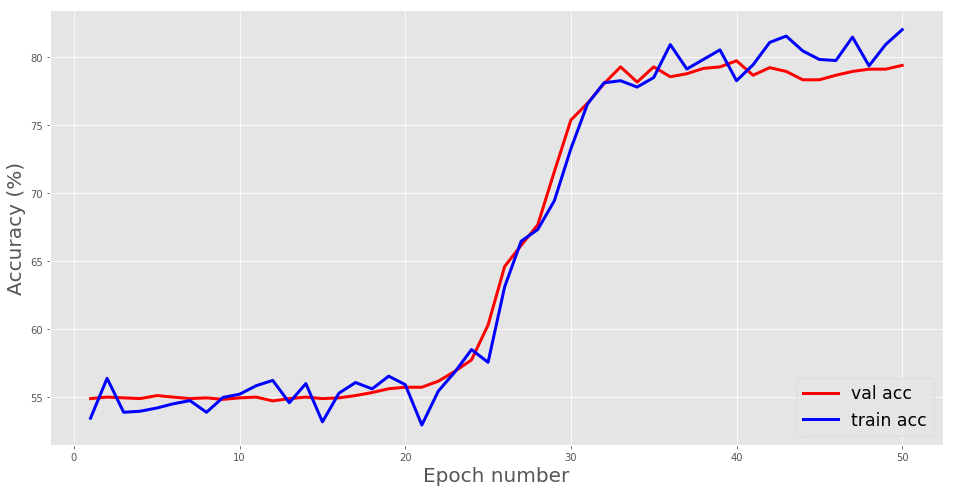

In [53]:
plt.figure(figsize=(16, 8))
epochs = np.arange(1,num_epochs+1)
#custom_lines = [Line2D([0], [0], color = 'red', lw=3),
#                Line2D([0], [0], color = 'blue', lw=3),
#                Line2D([0], [0], color = 'orange', lw=3),
#                Line2D([0], [0], color = 'green', lw=3)]
plt.plot(epochs, avg_pool['val_acc']*100, color='red', label= 'val acc', linewidth = 3)
plt.plot(epochs, avg_pool['train_acc']*100, color='blue', label= 'train acc', linewidth = 3)
plt.ylabel('Accuracy (%)', fontsize = 20)
plt.xlabel('Epoch number', fontsize = 20)
plt.legend(loc='lower right', fontsize = 'xx-large')
plt.savefig('avg_acc.png')

## Experiment 1 LA - average pool 100 epochs

In [55]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 3
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'average_pool_100'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])
use GPU


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6924, accuracy: 0.5938:  20%|██        | 2/10 [00:00<00:00, 16.28it/s]

Epoch 0: train_acc_0.5359_train_loss_0.6928_val_acc_0.5525_val_loss_0.6923 epoch time 1.4356 seconds


loss: 0.6860, accuracy: 0.5938:  20%|██        | 2/10 [00:00<00:00, 13.83it/s]

Epoch 1: train_acc_0.5656_train_loss_0.6912_val_acc_0.5530_val_loss_0.6889 epoch time 1.4514 seconds


loss: 0.6855, accuracy: 0.5312:  20%|██        | 2/10 [00:00<00:00, 13.50it/s]

Epoch 2: train_acc_0.5594_train_loss_0.6864_val_acc_0.5530_val_loss_0.6827 epoch time 1.4850 seconds


loss: 0.6857, accuracy: 0.4453:  20%|██        | 2/10 [00:00<00:00, 15.13it/s]

Epoch 3: train_acc_0.5508_train_loss_0.6809_val_acc_0.5513_val_loss_0.6743 epoch time 1.4479 seconds


loss: 0.6699, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 15.85it/s]

Epoch 4: train_acc_0.5383_train_loss_0.6719_val_acc_0.5519_val_loss_0.6647 epoch time 1.4319 seconds


loss: 0.6607, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 13.31it/s]

Epoch 5: train_acc_0.5578_train_loss_0.6622_val_acc_0.5519_val_loss_0.6554 epoch time 1.4385 seconds


loss: 0.6515, accuracy: 0.5312:  20%|██        | 2/10 [00:00<00:00, 13.53it/s]

Epoch 6: train_acc_0.5797_train_loss_0.6452_val_acc_0.5525_val_loss_0.6465 epoch time 1.5087 seconds


loss: 0.6350, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 14.77it/s]

Epoch 7: train_acc_0.5516_train_loss_0.6423_val_acc_0.5530_val_loss_0.6403 epoch time 1.4626 seconds


loss: 0.6611, accuracy: 0.4531:  20%|██        | 2/10 [00:00<00:00, 15.68it/s]

Epoch 8: train_acc_0.5578_train_loss_0.6389_val_acc_0.5541_val_loss_0.6346 epoch time 1.4915 seconds


loss: 0.6422, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 13.56it/s]

Epoch 9: train_acc_0.5422_train_loss_0.6362_val_acc_0.5502_val_loss_0.6324 epoch time 1.4618 seconds


loss: 0.6247, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 13.63it/s]

Epoch 10: train_acc_0.5578_train_loss_0.6269_val_acc_0.5525_val_loss_0.6281 epoch time 1.4879 seconds


loss: 0.5933, accuracy: 0.6094:  20%|██        | 2/10 [00:00<00:00, 15.36it/s]

Epoch 11: train_acc_0.5586_train_loss_0.6304_val_acc_0.5513_val_loss_0.6254 epoch time 1.4371 seconds


loss: 0.6195, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 15.78it/s]

Epoch 12: train_acc_0.5477_train_loss_0.6270_val_acc_0.5513_val_loss_0.6230 epoch time 1.4204 seconds


loss: 0.6003, accuracy: 0.6172:  20%|██        | 2/10 [00:00<00:00, 13.39it/s]

Epoch 13: train_acc_0.5336_train_loss_0.6283_val_acc_0.5530_val_loss_0.6193 epoch time 1.4392 seconds


loss: 0.6323, accuracy: 0.4766:  20%|██        | 2/10 [00:00<00:00, 13.27it/s]

Epoch 14: train_acc_0.5578_train_loss_0.6160_val_acc_0.5519_val_loss_0.6169 epoch time 1.5060 seconds


loss: 0.5967, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 14.85it/s]

Epoch 15: train_acc_0.5617_train_loss_0.6091_val_acc_0.5525_val_loss_0.6134 epoch time 1.4436 seconds


loss: 0.6565, accuracy: 0.4531:  20%|██        | 2/10 [00:00<00:00, 15.48it/s]

Epoch 16: train_acc_0.5539_train_loss_0.6161_val_acc_0.5536_val_loss_0.6103 epoch time 1.4265 seconds


loss: 0.6151, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]

Epoch 17: train_acc_0.5461_train_loss_0.6176_val_acc_0.5536_val_loss_0.6076 epoch time 1.4341 seconds


loss: 0.5929, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 13.48it/s]

Epoch 18: train_acc_0.5547_train_loss_0.6161_val_acc_0.5552_val_loss_0.6047 epoch time 1.5024 seconds


loss: 0.5876, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 19: train_acc_0.5523_train_loss_0.6128_val_acc_0.5575_val_loss_0.6027 epoch time 1.4586 seconds


loss: 0.6330, accuracy: 0.4766:  20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 20: train_acc_0.5320_train_loss_0.6122_val_acc_0.5586_val_loss_0.6006 epoch time 1.4335 seconds


loss: 0.6248, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 14.15it/s]

Epoch 21: train_acc_0.5555_train_loss_0.6015_val_acc_0.5592_val_loss_0.5989 epoch time 1.4410 seconds


loss: 0.6084, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 13.26it/s]

Epoch 22: train_acc_0.5469_train_loss_0.6081_val_acc_0.5614_val_loss_0.5970 epoch time 1.5001 seconds


loss: 0.6145, accuracy: 0.5312:  20%|██        | 2/10 [00:00<00:00, 13.83it/s]

Epoch 23: train_acc_0.5531_train_loss_0.6045_val_acc_0.5647_val_loss_0.5947 epoch time 1.4625 seconds


loss: 0.5783, accuracy: 0.6328:  20%|██        | 2/10 [00:00<00:00, 16.38it/s]

Epoch 24: train_acc_0.5687_train_loss_0.5964_val_acc_0.5658_val_loss_0.5933 epoch time 1.4260 seconds


loss: 0.5990, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 13.87it/s]

Epoch 25: train_acc_0.5672_train_loss_0.5952_val_acc_0.5703_val_loss_0.5910 epoch time 1.4235 seconds


loss: 0.5744, accuracy: 0.6641:  20%|██        | 2/10 [00:00<00:00, 13.45it/s]

Epoch 26: train_acc_0.5781_train_loss_0.5910_val_acc_0.5876_val_loss_0.5886 epoch time 1.5061 seconds


loss: 0.5874, accuracy: 0.6250:  20%|██        | 2/10 [00:00<00:00, 13.91it/s]

Epoch 27: train_acc_0.5961_train_loss_0.5999_val_acc_0.6004_val_loss_0.5864 epoch time 1.4634 seconds


loss: 0.5978, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 15.77it/s]

Epoch 28: train_acc_0.5922_train_loss_0.5934_val_acc_0.6205_val_loss_0.5853 epoch time 1.5074 seconds


loss: 0.6050, accuracy: 0.6484:  20%|██        | 2/10 [00:00<00:00, 13.16it/s]

Epoch 29: train_acc_0.6391_train_loss_0.5846_val_acc_0.6334_val_loss_0.5834 epoch time 1.4384 seconds


loss: 0.5966, accuracy: 0.6484:  20%|██        | 2/10 [00:00<00:00, 13.28it/s]

Epoch 30: train_acc_0.6570_train_loss_0.5891_val_acc_0.6735_val_loss_0.5802 epoch time 1.5131 seconds


loss: 0.5993, accuracy: 0.6641:  20%|██        | 2/10 [00:00<00:00, 14.63it/s]

Epoch 31: train_acc_0.6680_train_loss_0.5903_val_acc_0.7137_val_loss_0.5792 epoch time 1.4545 seconds


loss: 0.5729, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 15.60it/s]

Epoch 32: train_acc_0.7180_train_loss_0.5834_val_acc_0.7316_val_loss_0.5755 epoch time 1.4313 seconds


loss: 0.6071, accuracy: 0.6797:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 33: train_acc_0.7125_train_loss_0.5794_val_acc_0.7511_val_loss_0.5730 epoch time 1.4306 seconds


loss: 0.5894, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 14.00it/s]

Epoch 34: train_acc_0.7586_train_loss_0.5777_val_acc_0.7746_val_loss_0.5689 epoch time 1.4977 seconds


loss: 0.5934, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 14.11it/s]

Epoch 35: train_acc_0.7703_train_loss_0.5788_val_acc_0.7941_val_loss_0.5643 epoch time 1.4505 seconds


loss: 0.5485, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.30it/s]

Epoch 36: train_acc_0.7906_train_loss_0.5650_val_acc_0.7941_val_loss_0.5603 epoch time 1.4319 seconds


loss: 0.5649, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 13.73it/s]

Epoch 37: train_acc_0.8000_train_loss_0.5527_val_acc_0.7946_val_loss_0.5556 epoch time 1.4168 seconds


loss: 0.5788, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 13.73it/s]

Epoch 38: train_acc_0.7789_train_loss_0.5619_val_acc_0.7952_val_loss_0.5517 epoch time 1.4887 seconds


loss: 0.5225, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.17it/s]

Epoch 39: train_acc_0.7773_train_loss_0.5573_val_acc_0.7941_val_loss_0.5487 epoch time 1.4637 seconds


loss: 0.5210, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.34it/s]

Epoch 40: train_acc_0.7867_train_loss_0.5463_val_acc_0.7974_val_loss_0.5445 epoch time 1.4202 seconds


loss: 0.5587, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 41: train_acc_0.7953_train_loss_0.5424_val_acc_0.8086_val_loss_0.5385 epoch time 1.4196 seconds


loss: 0.5568, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 14.03it/s]

Epoch 42: train_acc_0.8141_train_loss_0.5278_val_acc_0.7997_val_loss_0.5364 epoch time 1.4869 seconds


loss: 0.5389, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.75it/s]

Epoch 43: train_acc_0.8102_train_loss_0.5240_val_acc_0.8097_val_loss_0.5313 epoch time 1.4767 seconds


loss: 0.4962, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 44: train_acc_0.7781_train_loss_0.5483_val_acc_0.8086_val_loss_0.5293 epoch time 1.4297 seconds


loss: 0.5553, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 14.73it/s]

Epoch 45: train_acc_0.8203_train_loss_0.5168_val_acc_0.8092_val_loss_0.5257 epoch time 1.4194 seconds


loss: 0.6104, accuracy: 0.7031:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]

Epoch 46: train_acc_0.8172_train_loss_0.5123_val_acc_0.8097_val_loss_0.5221 epoch time 1.4680 seconds


loss: 0.5139, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.23it/s]

Epoch 47: train_acc_0.8047_train_loss_0.5237_val_acc_0.8080_val_loss_0.5209 epoch time 1.4762 seconds


loss: 0.5507, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 48: train_acc_0.8094_train_loss_0.5217_val_acc_0.8103_val_loss_0.5171 epoch time 1.4975 seconds


loss: 0.4768, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.94it/s]

Epoch 49: train_acc_0.7648_train_loss_0.5402_val_acc_0.8125_val_loss_0.5146 epoch time 1.4138 seconds


loss: 0.5600, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]

Epoch 50: train_acc_0.8031_train_loss_0.5226_val_acc_0.8036_val_loss_0.5163 epoch time 1.4677 seconds


loss: 0.4908, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.02it/s]

Epoch 51: train_acc_0.7867_train_loss_0.5307_val_acc_0.8125_val_loss_0.5126 epoch time 1.4913 seconds


loss: 0.5403, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 16.37it/s]

Epoch 52: train_acc_0.8000_train_loss_0.5179_val_acc_0.8080_val_loss_0.5130 epoch time 1.4411 seconds


loss: 0.5044, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 15.80it/s]

Epoch 53: train_acc_0.7984_train_loss_0.5185_val_acc_0.7941_val_loss_0.5170 epoch time 1.4120 seconds


loss: 0.5159, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.05it/s]

Epoch 54: train_acc_0.8063_train_loss_0.5070_val_acc_0.8142_val_loss_0.5076 epoch time 1.4521 seconds


loss: 0.5034, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.63it/s]

Epoch 55: train_acc_0.8172_train_loss_0.5034_val_acc_0.8142_val_loss_0.5070 epoch time 1.4939 seconds


loss: 0.5158, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 16.25it/s]

Epoch 56: train_acc_0.8078_train_loss_0.5090_val_acc_0.8114_val_loss_0.5066 epoch time 1.4356 seconds


loss: 0.5527, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 57: train_acc_0.8148_train_loss_0.5006_val_acc_0.8175_val_loss_0.5040 epoch time 1.4139 seconds


loss: 0.4956, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 13.71it/s]

Epoch 58: train_acc_0.8047_train_loss_0.5111_val_acc_0.8164_val_loss_0.5025 epoch time 1.4472 seconds


loss: 0.5334, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.63it/s]

Epoch 59: train_acc_0.8031_train_loss_0.5057_val_acc_0.8164_val_loss_0.5023 epoch time 1.4880 seconds


loss: 0.5019, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 15.18it/s]

Epoch 60: train_acc_0.8047_train_loss_0.5074_val_acc_0.8153_val_loss_0.5020 epoch time 1.4398 seconds


loss: 0.4749, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 16.27it/s]

Epoch 61: train_acc_0.8141_train_loss_0.5052_val_acc_0.8153_val_loss_0.5010 epoch time 1.4203 seconds


loss: 0.5222, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.96it/s]

Epoch 62: train_acc_0.8187_train_loss_0.4909_val_acc_0.8147_val_loss_0.5005 epoch time 1.4351 seconds


loss: 0.4849, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.15it/s]

Epoch 63: train_acc_0.8141_train_loss_0.4971_val_acc_0.8086_val_loss_0.5039 epoch time 1.4978 seconds


loss: 0.4812, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.91it/s]

Epoch 64: train_acc_0.8102_train_loss_0.5004_val_acc_0.8175_val_loss_0.4987 epoch time 1.4658 seconds


loss: 0.5353, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 16.18it/s]

Epoch 65: train_acc_0.8313_train_loss_0.4819_val_acc_0.8198_val_loss_0.4966 epoch time 1.4210 seconds


loss: 0.5025, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 66: train_acc_0.8211_train_loss_0.4954_val_acc_0.8164_val_loss_0.4993 epoch time 1.4145 seconds


loss: 0.5490, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 67: train_acc_0.8313_train_loss_0.4861_val_acc_0.8170_val_loss_0.4986 epoch time 1.4923 seconds


loss: 0.5437, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 15.27it/s]

Epoch 68: train_acc_0.8219_train_loss_0.4920_val_acc_0.8158_val_loss_0.4978 epoch time 1.5433 seconds


loss: 0.4655, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.24it/s]

Epoch 69: train_acc_0.8000_train_loss_0.5135_val_acc_0.8192_val_loss_0.4944 epoch time 1.4220 seconds


loss: 0.5010, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 70: train_acc_0.8250_train_loss_0.4900_val_acc_0.8231_val_loss_0.4928 epoch time 1.4270 seconds


loss: 0.4114, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.17it/s]

Epoch 71: train_acc_0.8047_train_loss_0.5087_val_acc_0.8214_val_loss_0.4937 epoch time 1.4941 seconds


loss: 0.5253, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 14.68it/s]

Epoch 72: train_acc_0.8195_train_loss_0.4876_val_acc_0.8136_val_loss_0.4972 epoch time 1.4622 seconds


loss: 0.5237, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 16.33it/s]

Epoch 73: train_acc_0.8086_train_loss_0.5028_val_acc_0.8220_val_loss_0.4928 epoch time 1.4220 seconds


loss: 0.5169, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.71it/s]

Epoch 74: train_acc_0.8180_train_loss_0.4938_val_acc_0.8192_val_loss_0.4943 epoch time 1.4216 seconds


loss: 0.5238, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 75: train_acc_0.8156_train_loss_0.4970_val_acc_0.8231_val_loss_0.4919 epoch time 1.4893 seconds


loss: 0.4909, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.09it/s]

Epoch 76: train_acc_0.8070_train_loss_0.4999_val_acc_0.8237_val_loss_0.4919 epoch time 1.4693 seconds


loss: 0.4737, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 16.29it/s]

Epoch 77: train_acc_0.8180_train_loss_0.4914_val_acc_0.8220_val_loss_0.4918 epoch time 1.4234 seconds


loss: 0.5308, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 13.52it/s]

Epoch 78: train_acc_0.8086_train_loss_0.5004_val_acc_0.8237_val_loss_0.4911 epoch time 1.4208 seconds


loss: 0.4874, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.16it/s]

Epoch 79: train_acc_0.8383_train_loss_0.4742_val_acc_0.8253_val_loss_0.4902 epoch time 1.4914 seconds


loss: 0.4972, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.12it/s]

Epoch 80: train_acc_0.8305_train_loss_0.4822_val_acc_0.8225_val_loss_0.4913 epoch time 1.4748 seconds


loss: 0.5105, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 16.01it/s]

Epoch 81: train_acc_0.8094_train_loss_0.4961_val_acc_0.8248_val_loss_0.4892 epoch time 1.4340 seconds


loss: 0.4636, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.76it/s]

Epoch 82: train_acc_0.8187_train_loss_0.4916_val_acc_0.8220_val_loss_0.4909 epoch time 1.4199 seconds


loss: 0.5217, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.59it/s]

Epoch 83: train_acc_0.8258_train_loss_0.4828_val_acc_0.8248_val_loss_0.4891 epoch time 1.4770 seconds


loss: 0.4998, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.29it/s]

Epoch 84: train_acc_0.8258_train_loss_0.4843_val_acc_0.8281_val_loss_0.4881 epoch time 1.4722 seconds


loss: 0.4755, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 15.77it/s]

Epoch 85: train_acc_0.8203_train_loss_0.4858_val_acc_0.8265_val_loss_0.4881 epoch time 1.4283 seconds


loss: 0.5063, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.79it/s]

Epoch 86: train_acc_0.8125_train_loss_0.4948_val_acc_0.8276_val_loss_0.4880 epoch time 1.4301 seconds


loss: 0.5078, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.30it/s]

Epoch 87: train_acc_0.8086_train_loss_0.5002_val_acc_0.8253_val_loss_0.4879 epoch time 1.4669 seconds


loss: 0.4917, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]

Epoch 88: train_acc_0.8156_train_loss_0.4915_val_acc_0.8242_val_loss_0.4886 epoch time 1.5656 seconds


loss: 0.4593, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 15.98it/s]

Epoch 89: train_acc_0.8102_train_loss_0.5001_val_acc_0.8304_val_loss_0.4872 epoch time 1.4368 seconds


loss: 0.4607, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.18it/s]

Epoch 90: train_acc_0.8359_train_loss_0.4758_val_acc_0.8298_val_loss_0.4866 epoch time 1.4316 seconds


loss: 0.4910, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.64it/s]

Epoch 91: train_acc_0.8391_train_loss_0.4685_val_acc_0.8270_val_loss_0.4871 epoch time 1.4852 seconds


loss: 0.4754, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.69it/s]

Epoch 92: train_acc_0.8273_train_loss_0.4844_val_acc_0.8276_val_loss_0.4872 epoch time 1.4705 seconds


loss: 0.5184, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 15.62it/s]

Epoch 93: train_acc_0.8141_train_loss_0.4971_val_acc_0.8186_val_loss_0.4902 epoch time 1.4377 seconds


loss: 0.5256, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.64it/s]

Epoch 94: train_acc_0.8266_train_loss_0.4814_val_acc_0.8287_val_loss_0.4863 epoch time 1.4266 seconds


loss: 0.4523, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.62it/s]

Epoch 95: train_acc_0.8141_train_loss_0.4955_val_acc_0.8248_val_loss_0.4877 epoch time 1.4680 seconds


loss: 0.5113, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 12.99it/s]

Epoch 96: train_acc_0.8430_train_loss_0.4692_val_acc_0.8287_val_loss_0.4869 epoch time 1.4848 seconds


loss: 0.4762, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 15.69it/s]

Epoch 97: train_acc_0.8133_train_loss_0.4955_val_acc_0.8248_val_loss_0.4878 epoch time 1.4377 seconds


loss: 0.4840, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 15.13it/s]

Epoch 98: train_acc_0.8086_train_loss_0.5046_val_acc_0.8276_val_loss_0.4864 epoch time 1.4120 seconds


loss: 0.5013, accuracy: 0.8125:  21%|██▏       | 3/14 [00:00<00:00, 34.93it/s]

Epoch 99: train_acc_0.8273_train_loss_0.4846_val_acc_0.8248_val_loss_0.4879 epoch time 1.4793 seconds
Generating test set evaluation metrics


loss: 0.4961, accuracy: 0.8125: 100%|██████████| 14/14 [00:00<00:00, 34.28it/s]


TOTAL TIME 149.9524


## Experiment 4 LA - changing the batch size: 100 epochs - max pool
* 64
* 128 baseiline
* 256 

In [56]:
batch_size = 64
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'batch_64'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (64, 1, 128, 128)
torch.Size([64, 32, 128, 128])
torch.Size([64, 32, 64, 64])
torch.Size([64, 64, 64, 64])
torch.Size([64, 64, 32, 32])
torch.Size([64, 194, 32, 32])
torch.Size([64, 194, 16, 16])
Block is built, output volume is torch.Size([64, 2])
use GPU


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6864, accuracy: 0.4375:  40%|████      | 4/10 [00:00<00:00, 27.98it/s]

Epoch 0: train_acc_0.5437_train_loss_0.6896_val_acc_0.5497_val_loss_0.6908 epoch time 1.1834 seconds


loss: 0.6796, accuracy: 0.4688:  40%|████      | 4/10 [00:00<00:00, 29.19it/s]

Epoch 1: train_acc_0.5500_train_loss_0.6802_val_acc_0.5502_val_loss_0.6858 epoch time 1.1260 seconds


loss: 0.6436, accuracy: 0.5000:  40%|████      | 4/10 [00:00<00:00, 27.09it/s]

Epoch 2: train_acc_0.5359_train_loss_0.6697_val_acc_0.5497_val_loss_0.6791 epoch time 1.1139 seconds


loss: 0.6310, accuracy: 0.5781:  40%|████      | 4/10 [00:00<00:00, 27.76it/s]

Epoch 3: train_acc_0.5672_train_loss_0.6464_val_acc_0.5491_val_loss_0.6707 epoch time 1.1168 seconds


loss: 0.5986, accuracy: 0.6875:  40%|████      | 4/10 [00:00<00:00, 28.88it/s]

Epoch 4: train_acc_0.5281_train_loss_0.6558_val_acc_0.5508_val_loss_0.6676 epoch time 1.1084 seconds


loss: 0.6394, accuracy: 0.5312:  40%|████      | 4/10 [00:00<00:00, 28.69it/s]

Epoch 5: train_acc_0.5563_train_loss_0.6341_val_acc_0.5491_val_loss_0.6616 epoch time 1.0980 seconds


loss: 0.6973, accuracy: 0.3906:  40%|████      | 4/10 [00:00<00:00, 27.90it/s]

Epoch 6: train_acc_0.5188_train_loss_0.6488_val_acc_0.5497_val_loss_0.6595 epoch time 1.0993 seconds


loss: 0.5939, accuracy: 0.6719:  40%|████      | 4/10 [00:00<00:00, 28.14it/s]

Epoch 7: train_acc_0.5359_train_loss_0.6316_val_acc_0.5513_val_loss_0.6550 epoch time 1.0895 seconds


loss: 0.6404, accuracy: 0.5469:  40%|████      | 4/10 [00:00<00:00, 28.44it/s]

Epoch 8: train_acc_0.5672_train_loss_0.6224_val_acc_0.5519_val_loss_0.6505 epoch time 1.0859 seconds


loss: 0.6202, accuracy: 0.5469:  40%|████      | 4/10 [00:00<00:00, 29.48it/s]

Epoch 9: train_acc_0.5500_train_loss_0.6203_val_acc_0.5530_val_loss_0.6465 epoch time 1.0881 seconds


loss: 0.5637, accuracy: 0.6719:  50%|█████     | 5/10 [00:00<00:00, 32.55it/s]

Epoch 10: train_acc_0.5734_train_loss_0.6025_val_acc_0.5530_val_loss_0.6413 epoch time 1.0893 seconds


loss: 0.5756, accuracy: 0.6406:  50%|█████     | 5/10 [00:00<00:00, 32.60it/s]

Epoch 11: train_acc_0.5703_train_loss_0.6113_val_acc_0.5541_val_loss_0.6387 epoch time 1.0988 seconds


loss: 0.6097, accuracy: 0.5469:  50%|█████     | 5/10 [00:00<00:00, 32.60it/s]

Epoch 12: train_acc_0.5828_train_loss_0.5926_val_acc_0.5547_val_loss_0.6328 epoch time 1.0845 seconds


loss: 0.6045, accuracy: 0.5469:  50%|█████     | 5/10 [00:00<00:00, 30.70it/s]

Epoch 13: train_acc_0.5234_train_loss_0.6107_val_acc_0.5642_val_loss_0.6357 epoch time 1.0671 seconds


loss: 0.5516, accuracy: 0.6406:  40%|████      | 4/10 [00:00<00:00, 27.60it/s]

Epoch 14: train_acc_0.5609_train_loss_0.6001_val_acc_0.5731_val_loss_0.6326 epoch time 1.0676 seconds


loss: 0.5561, accuracy: 0.7031:  40%|████      | 4/10 [00:00<00:00, 28.57it/s]

Epoch 15: train_acc_0.6219_train_loss_0.5718_val_acc_0.5804_val_loss_0.6274 epoch time 1.0838 seconds


loss: 0.5552, accuracy: 0.6562:  40%|████      | 4/10 [00:00<00:00, 27.56it/s]

Epoch 16: train_acc_0.6141_train_loss_0.5913_val_acc_0.6300_val_loss_0.6251 epoch time 1.0888 seconds


loss: 0.5558, accuracy: 0.7344:  40%|████      | 4/10 [00:00<00:00, 26.61it/s]

Epoch 17: train_acc_0.6844_train_loss_0.5858_val_acc_0.7305_val_loss_0.6254 epoch time 1.1307 seconds


loss: 0.5976, accuracy: 0.6094:  40%|████      | 4/10 [00:00<00:00, 26.87it/s]

Epoch 18: train_acc_0.7672_train_loss_0.5584_val_acc_0.6920_val_loss_0.6178 epoch time 1.1152 seconds


loss: 0.5876, accuracy: 0.7656:  40%|████      | 4/10 [00:00<00:00, 27.23it/s]

Epoch 19: train_acc_0.6969_train_loss_0.5847_val_acc_0.7829_val_loss_0.6204 epoch time 1.1140 seconds


loss: 0.6050, accuracy: 0.7344:  40%|████      | 4/10 [00:00<00:00, 29.36it/s]

Epoch 20: train_acc_0.7719_train_loss_0.5806_val_acc_0.7779_val_loss_0.6146 epoch time 1.1263 seconds


loss: 0.5645, accuracy: 0.8125:  40%|████      | 4/10 [00:00<00:00, 28.88it/s]

Epoch 21: train_acc_0.7734_train_loss_0.5859_val_acc_0.7958_val_loss_0.6146 epoch time 1.0970 seconds


loss: 0.5551, accuracy: 0.7812:  30%|███       | 3/10 [00:00<00:00, 19.66it/s]

Epoch 22: train_acc_0.8172_train_loss_0.5486_val_acc_0.7930_val_loss_0.6105 epoch time 1.1423 seconds


loss: 0.5611, accuracy: 0.7656:  40%|████      | 4/10 [00:00<00:00, 26.87it/s]

Epoch 23: train_acc_0.8156_train_loss_0.5399_val_acc_0.7930_val_loss_0.6048 epoch time 1.1743 seconds


loss: 0.5363, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 27.22it/s]

Epoch 24: train_acc_0.7750_train_loss_0.5531_val_acc_0.7952_val_loss_0.6019 epoch time 1.1160 seconds


loss: 0.5828, accuracy: 0.7969:  40%|████      | 4/10 [00:00<00:00, 26.73it/s]

Epoch 25: train_acc_0.8016_train_loss_0.5470_val_acc_0.7980_val_loss_0.5984 epoch time 1.0940 seconds


loss: 0.5197, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 29.44it/s]

Epoch 26: train_acc_0.7750_train_loss_0.5672_val_acc_0.7974_val_loss_0.5950 epoch time 1.0940 seconds


loss: 0.4620, accuracy: 0.9062:  40%|████      | 4/10 [00:00<00:00, 25.88it/s]

Epoch 27: train_acc_0.8031_train_loss_0.5308_val_acc_0.7946_val_loss_0.5932 epoch time 1.0667 seconds


loss: 0.5142, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 29.85it/s]

Epoch 28: train_acc_0.8000_train_loss_0.5271_val_acc_0.7974_val_loss_0.5877 epoch time 1.0939 seconds


loss: 0.4950, accuracy: 0.8438:  50%|█████     | 5/10 [00:00<00:00, 32.51it/s]

Epoch 29: train_acc_0.8016_train_loss_0.5377_val_acc_0.7958_val_loss_0.5856 epoch time 1.0911 seconds


loss: 0.5042, accuracy: 0.7812:  50%|█████     | 5/10 [00:00<00:00, 32.52it/s]

Epoch 30: train_acc_0.8266_train_loss_0.5080_val_acc_0.7980_val_loss_0.5821 epoch time 1.0844 seconds


loss: 0.5696, accuracy: 0.7500:  50%|█████     | 5/10 [00:00<00:00, 29.92it/s]

Epoch 31: train_acc_0.7969_train_loss_0.5237_val_acc_0.7991_val_loss_0.5795 epoch time 1.0954 seconds


loss: 0.5162, accuracy: 0.8125:  50%|█████     | 5/10 [00:00<00:00, 32.48it/s]

Epoch 32: train_acc_0.8172_train_loss_0.5111_val_acc_0.8008_val_loss_0.5760 epoch time 1.0926 seconds


loss: 0.5516, accuracy: 0.7656:  50%|█████     | 5/10 [00:00<00:00, 31.47it/s]

Epoch 33: train_acc_0.7953_train_loss_0.5275_val_acc_0.7985_val_loss_0.5743 epoch time 1.0772 seconds


loss: 0.5099, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 27.66it/s]

Epoch 34: train_acc_0.8125_train_loss_0.5065_val_acc_0.8002_val_loss_0.5725 epoch time 1.0737 seconds


loss: 0.5228, accuracy: 0.7812:  40%|████      | 4/10 [00:00<00:00, 26.46it/s]

Epoch 35: train_acc_0.8047_train_loss_0.5167_val_acc_0.7991_val_loss_0.5701 epoch time 1.0901 seconds


loss: 0.4908, accuracy: 0.8594:  40%|████      | 4/10 [00:00<00:00, 27.41it/s]

Epoch 36: train_acc_0.8063_train_loss_0.5103_val_acc_0.8036_val_loss_0.5670 epoch time 1.0989 seconds


loss: 0.5691, accuracy: 0.7344:  40%|████      | 4/10 [00:00<00:00, 27.85it/s]

Epoch 37: train_acc_0.8375_train_loss_0.4917_val_acc_0.8019_val_loss_0.5660 epoch time 1.1128 seconds


loss: 0.4999, accuracy: 0.8125:  40%|████      | 4/10 [00:00<00:00, 27.98it/s]

Epoch 38: train_acc_0.8016_train_loss_0.5148_val_acc_0.8058_val_loss_0.5625 epoch time 1.1307 seconds


loss: 0.4806, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 27.64it/s]

Epoch 39: train_acc_0.8234_train_loss_0.4962_val_acc_0.8069_val_loss_0.5616 epoch time 1.1223 seconds


loss: 0.5368, accuracy: 0.7656:  40%|████      | 4/10 [00:00<00:00, 27.19it/s]

Epoch 40: train_acc_0.8078_train_loss_0.5053_val_acc_0.8069_val_loss_0.5602 epoch time 1.1104 seconds


loss: 0.5088, accuracy: 0.7812:  40%|████      | 4/10 [00:00<00:00, 29.40it/s]

Epoch 41: train_acc_0.8047_train_loss_0.5102_val_acc_0.8097_val_loss_0.5587 epoch time 1.1095 seconds


loss: 0.4420, accuracy: 0.8906:  40%|████      | 4/10 [00:00<00:00, 25.80it/s]

Epoch 42: train_acc_0.8094_train_loss_0.5014_val_acc_0.8080_val_loss_0.5562 epoch time 1.0902 seconds


loss: 0.5015, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 28.66it/s]

Epoch 43: train_acc_0.8391_train_loss_0.4826_val_acc_0.8108_val_loss_0.5547 epoch time 1.1012 seconds


loss: 0.5670, accuracy: 0.7344:  40%|████      | 4/10 [00:00<00:00, 27.36it/s]

Epoch 44: train_acc_0.8328_train_loss_0.4870_val_acc_0.8097_val_loss_0.5544 epoch time 1.0743 seconds


loss: 0.5472, accuracy: 0.7656:  40%|████      | 4/10 [00:00<00:00, 27.26it/s]

Epoch 45: train_acc_0.8219_train_loss_0.4914_val_acc_0.8114_val_loss_0.5521 epoch time 1.0990 seconds


loss: 0.4794, accuracy: 0.8750:  40%|████      | 4/10 [00:00<00:00, 28.63it/s]

Epoch 46: train_acc_0.7969_train_loss_0.5151_val_acc_0.8114_val_loss_0.5517 epoch time 1.0882 seconds


loss: 0.5322, accuracy: 0.7500:  40%|████      | 4/10 [00:00<00:00, 27.93it/s]

Epoch 47: train_acc_0.8422_train_loss_0.4821_val_acc_0.8136_val_loss_0.5501 epoch time 1.2743 seconds


loss: 0.5584, accuracy: 0.7656:  30%|███       | 3/10 [00:00<00:00, 20.75it/s]

Epoch 48: train_acc_0.8281_train_loss_0.4842_val_acc_0.8092_val_loss_0.5485 epoch time 1.0915 seconds


loss: 0.4701, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 29.86it/s]

Epoch 49: train_acc_0.8297_train_loss_0.4819_val_acc_0.8080_val_loss_0.5504 epoch time 1.1629 seconds


loss: 0.4493, accuracy: 0.8750:  50%|█████     | 5/10 [00:00<00:00, 31.75it/s]

Epoch 50: train_acc_0.7937_train_loss_0.5116_val_acc_0.8136_val_loss_0.5475 epoch time 1.0876 seconds


loss: 0.4615, accuracy: 0.8438:  50%|█████     | 5/10 [00:00<00:00, 32.57it/s]

Epoch 51: train_acc_0.8328_train_loss_0.4835_val_acc_0.8108_val_loss_0.5478 epoch time 1.0882 seconds


loss: 0.5383, accuracy: 0.7656:  50%|█████     | 5/10 [00:00<00:00, 31.20it/s]

Epoch 52: train_acc_0.8406_train_loss_0.4715_val_acc_0.8175_val_loss_0.5443 epoch time 1.0919 seconds


loss: 0.4630, accuracy: 0.8281:  50%|█████     | 5/10 [00:00<00:00, 32.36it/s]

Epoch 53: train_acc_0.8141_train_loss_0.4970_val_acc_0.8147_val_loss_0.5445 epoch time 1.0970 seconds


loss: 0.5228, accuracy: 0.7812:  50%|█████     | 5/10 [00:00<00:00, 32.23it/s]

Epoch 54: train_acc_0.8375_train_loss_0.4694_val_acc_0.8186_val_loss_0.5431 epoch time 1.0892 seconds


loss: 0.4112, accuracy: 0.9062:  50%|█████     | 5/10 [00:00<00:00, 30.93it/s]

Epoch 55: train_acc_0.8266_train_loss_0.4855_val_acc_0.8214_val_loss_0.5413 epoch time 1.0782 seconds


loss: 0.4125, accuracy: 0.9062:  40%|████      | 4/10 [00:00<00:00, 26.57it/s]

Epoch 56: train_acc_0.8422_train_loss_0.4675_val_acc_0.8220_val_loss_0.5404 epoch time 1.0839 seconds


loss: 0.5594, accuracy: 0.7344:  40%|████      | 4/10 [00:00<00:00, 29.57it/s]

Epoch 57: train_acc_0.8375_train_loss_0.4759_val_acc_0.8220_val_loss_0.5396 epoch time 1.1138 seconds


loss: 0.5267, accuracy: 0.7500:  40%|████      | 4/10 [00:00<00:00, 29.18it/s]

Epoch 58: train_acc_0.8313_train_loss_0.4809_val_acc_0.8231_val_loss_0.5391 epoch time 1.0962 seconds


loss: 0.4725, accuracy: 0.8594:  40%|████      | 4/10 [00:00<00:00, 27.18it/s]

Epoch 59: train_acc_0.7859_train_loss_0.5114_val_acc_0.8175_val_loss_0.5417 epoch time 1.0997 seconds


loss: 0.4384, accuracy: 0.8906:  40%|████      | 4/10 [00:00<00:00, 27.23it/s]

Epoch 60: train_acc_0.8266_train_loss_0.4903_val_acc_0.8237_val_loss_0.5374 epoch time 1.1187 seconds


loss: 0.4534, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 27.03it/s]

Epoch 61: train_acc_0.7719_train_loss_0.5312_val_acc_0.8220_val_loss_0.5389 epoch time 1.1095 seconds


loss: 0.4871, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 27.07it/s]

Epoch 62: train_acc_0.8375_train_loss_0.4760_val_acc_0.8253_val_loss_0.5367 epoch time 1.1155 seconds


loss: 0.5001, accuracy: 0.8125:  40%|████      | 4/10 [00:00<00:00, 28.47it/s]

Epoch 63: train_acc_0.8438_train_loss_0.4675_val_acc_0.8309_val_loss_0.5345 epoch time 1.1091 seconds


loss: 0.5019, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 29.27it/s]

Epoch 64: train_acc_0.8156_train_loss_0.5011_val_acc_0.8315_val_loss_0.5346 epoch time 1.1133 seconds


loss: 0.4600, accuracy: 0.8750:  40%|████      | 4/10 [00:00<00:00, 28.18it/s]

Epoch 65: train_acc_0.7984_train_loss_0.5068_val_acc_0.8309_val_loss_0.5335 epoch time 1.0923 seconds


loss: 0.4574, accuracy: 0.8594:  40%|████      | 4/10 [00:00<00:00, 27.10it/s]

Epoch 66: train_acc_0.8281_train_loss_0.4897_val_acc_0.8348_val_loss_0.5371 epoch time 1.0920 seconds


loss: 0.4784, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 26.93it/s]

Epoch 67: train_acc_0.8469_train_loss_0.4675_val_acc_0.8304_val_loss_0.5308 epoch time 1.0761 seconds


loss: 0.4679, accuracy: 0.8125:  40%|████      | 4/10 [00:00<00:00, 30.25it/s]

Epoch 68: train_acc_0.8297_train_loss_0.4893_val_acc_0.8348_val_loss_0.5291 epoch time 1.0993 seconds


loss: 0.5234, accuracy: 0.7969:  50%|█████     | 5/10 [00:00<00:00, 32.11it/s]

Epoch 69: train_acc_0.8297_train_loss_0.4731_val_acc_0.8343_val_loss_0.5291 epoch time 1.0843 seconds


loss: 0.4470, accuracy: 0.8438:  50%|█████     | 5/10 [00:00<00:00, 31.16it/s]

Epoch 70: train_acc_0.8406_train_loss_0.4766_val_acc_0.8331_val_loss_0.5270 epoch time 1.1035 seconds


loss: 0.4563, accuracy: 0.8438:  50%|█████     | 5/10 [00:00<00:00, 32.45it/s]

Epoch 71: train_acc_0.8328_train_loss_0.4760_val_acc_0.8343_val_loss_0.5258 epoch time 1.0962 seconds


loss: 0.4226, accuracy: 0.9062:  50%|█████     | 5/10 [00:00<00:00, 32.41it/s]

Epoch 72: train_acc_0.8594_train_loss_0.4523_val_acc_0.8371_val_loss_0.5245 epoch time 1.0885 seconds


loss: 0.4588, accuracy: 0.8594:  50%|█████     | 5/10 [00:00<00:00, 31.76it/s]

Epoch 73: train_acc_0.8375_train_loss_0.4733_val_acc_0.8348_val_loss_0.5242 epoch time 1.0787 seconds


loss: 0.4685, accuracy: 0.8438:  50%|█████     | 5/10 [00:00<00:00, 31.91it/s]

Epoch 74: train_acc_0.8516_train_loss_0.4648_val_acc_0.8415_val_loss_0.5240 epoch time 2.3920 seconds


loss: 0.4209, accuracy: 0.9062:  40%|████      | 4/10 [00:00<00:00, 28.58it/s]

Epoch 75: train_acc_0.8359_train_loss_0.4749_val_acc_0.8376_val_loss_0.5231 epoch time 1.0919 seconds


loss: 0.4701, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 26.53it/s]

Epoch 76: train_acc_0.8609_train_loss_0.4532_val_acc_0.8371_val_loss_0.5216 epoch time 1.1244 seconds


loss: 0.5182, accuracy: 0.7969:  40%|████      | 4/10 [00:00<00:00, 29.19it/s]

Epoch 77: train_acc_0.8672_train_loss_0.4487_val_acc_0.8426_val_loss_0.5231 epoch time 1.1129 seconds


loss: 0.5670, accuracy: 0.7188:  40%|████      | 4/10 [00:00<00:00, 28.79it/s]

Epoch 78: train_acc_0.8516_train_loss_0.4642_val_acc_0.8376_val_loss_0.5215 epoch time 1.1120 seconds


loss: 0.4368, accuracy: 0.8750:  40%|████      | 4/10 [00:00<00:00, 28.63it/s]

Epoch 79: train_acc_0.8375_train_loss_0.4697_val_acc_0.8304_val_loss_0.5258 epoch time 1.1176 seconds


loss: 0.4480, accuracy: 0.8594:  40%|████      | 4/10 [00:00<00:00, 27.98it/s]

Epoch 80: train_acc_0.8594_train_loss_0.4543_val_acc_0.8331_val_loss_0.5228 epoch time 1.1074 seconds


loss: 0.3657, accuracy: 0.9688:  40%|████      | 4/10 [00:00<00:00, 29.35it/s]

Epoch 81: train_acc_0.8266_train_loss_0.4743_val_acc_0.8398_val_loss_0.5204 epoch time 1.1386 seconds


loss: 0.5340, accuracy: 0.7969:  40%|████      | 4/10 [00:00<00:00, 27.00it/s]

Epoch 82: train_acc_0.8703_train_loss_0.4436_val_acc_0.8426_val_loss_0.5201 epoch time 1.1390 seconds


loss: 0.5079, accuracy: 0.7969:  40%|████      | 4/10 [00:00<00:00, 27.44it/s]

Epoch 83: train_acc_0.8391_train_loss_0.4661_val_acc_0.8415_val_loss_0.5174 epoch time 1.1449 seconds


loss: 0.4761, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 27.12it/s]

Epoch 84: train_acc_0.8625_train_loss_0.4502_val_acc_0.8443_val_loss_0.5164 epoch time 1.1288 seconds


loss: 0.5550, accuracy: 0.7500:  40%|████      | 4/10 [00:00<00:00, 28.92it/s]

Epoch 85: train_acc_0.8375_train_loss_0.4776_val_acc_0.8449_val_loss_0.5167 epoch time 1.1412 seconds


loss: 0.4440, accuracy: 0.8750:  40%|████      | 4/10 [00:00<00:00, 27.75it/s]

Epoch 86: train_acc_0.8484_train_loss_0.4550_val_acc_0.8438_val_loss_0.5176 epoch time 1.1258 seconds


loss: 0.4859, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 27.84it/s]

Epoch 87: train_acc_0.8594_train_loss_0.4524_val_acc_0.8432_val_loss_0.5173 epoch time 1.1129 seconds


loss: 0.4779, accuracy: 0.8281:  40%|████      | 4/10 [00:00<00:00, 26.45it/s]

Epoch 88: train_acc_0.8328_train_loss_0.4765_val_acc_0.8404_val_loss_0.5167 epoch time 1.1171 seconds


loss: 0.4383, accuracy: 0.8750:  40%|████      | 4/10 [00:00<00:00, 28.54it/s]

Epoch 89: train_acc_0.8562_train_loss_0.4597_val_acc_0.8449_val_loss_0.5190 epoch time 1.1147 seconds


loss: 0.4685, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 26.86it/s]

Epoch 90: train_acc_0.8625_train_loss_0.4470_val_acc_0.8438_val_loss_0.5161 epoch time 1.0886 seconds


loss: 0.4677, accuracy: 0.8438:  40%|████      | 4/10 [00:00<00:00, 26.69it/s]

Epoch 91: train_acc_0.8531_train_loss_0.4628_val_acc_0.8438_val_loss_0.5156 epoch time 1.1164 seconds


loss: 0.4533, accuracy: 0.8594:  40%|████      | 4/10 [00:00<00:00, 29.38it/s]

Epoch 92: train_acc_0.8438_train_loss_0.4619_val_acc_0.8443_val_loss_0.5153 epoch time 1.1247 seconds


loss: 0.4049, accuracy: 0.9219:  40%|████      | 4/10 [00:00<00:00, 28.72it/s]

Epoch 93: train_acc_0.8500_train_loss_0.4678_val_acc_0.8443_val_loss_0.5143 epoch time 1.0903 seconds


loss: 0.4395, accuracy: 0.8438:  50%|█████     | 5/10 [00:00<00:00, 31.45it/s]

Epoch 94: train_acc_0.8781_train_loss_0.4351_val_acc_0.8465_val_loss_0.5149 epoch time 1.1098 seconds


loss: 0.4894, accuracy: 0.8125:  50%|█████     | 5/10 [00:00<00:00, 31.51it/s]

Epoch 95: train_acc_0.8578_train_loss_0.4543_val_acc_0.8460_val_loss_0.5120 epoch time 1.1117 seconds


loss: 0.4530, accuracy: 0.8594:  50%|█████     | 5/10 [00:00<00:00, 32.39it/s]

Epoch 96: train_acc_0.8297_train_loss_0.4800_val_acc_0.8477_val_loss_0.5122 epoch time 1.1196 seconds


loss: 0.4484, accuracy: 0.8594:  50%|█████     | 5/10 [00:00<00:00, 32.37it/s]

Epoch 97: train_acc_0.8484_train_loss_0.4562_val_acc_0.8465_val_loss_0.5171 epoch time 1.1148 seconds


loss: 0.4379, accuracy: 0.8594:  50%|█████     | 5/10 [00:00<00:00, 31.44it/s]

Epoch 98: train_acc_0.8703_train_loss_0.4427_val_acc_0.8426_val_loss_0.5121 epoch time 1.1057 seconds


loss: 0.5536, accuracy: 0.8125:  29%|██▊       | 8/28 [00:00<00:00, 84.14it/s]

Epoch 99: train_acc_0.8609_train_loss_0.4485_val_acc_0.8516_val_loss_0.5102 epoch time 1.1013 seconds
Generating test set evaluation metrics


loss: 0.5701, accuracy: 0.8281: 100%|██████████| 28/28 [00:00<00:00, 69.83it/s]


TOTAL TIME 116.0760


In [58]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'batch_128_baseline'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6778, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 14.59it/s]

use GPU
Epoch 0: train_acc_0.5281_train_loss_0.6891_val_acc_0.5407_val_loss_0.6896 epoch time 1.4629 seconds


loss: 0.6490, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 16.93it/s]

Epoch 1: train_acc_0.5469_train_loss_0.6725_val_acc_0.5430_val_loss_0.6823 epoch time 1.4185 seconds


loss: 0.6770, accuracy: 0.4453:  20%|██        | 2/10 [00:00<00:00, 14.84it/s]

Epoch 2: train_acc_0.5414_train_loss_0.6502_val_acc_0.5424_val_loss_0.6736 epoch time 1.4064 seconds


loss: 0.6607, accuracy: 0.4688:  20%|██        | 2/10 [00:00<00:00, 13.15it/s]

Epoch 3: train_acc_0.5398_train_loss_0.6451_val_acc_0.5413_val_loss_0.6675 epoch time 1.5204 seconds


loss: 0.6173, accuracy: 0.5938:  20%|██        | 2/10 [00:00<00:00, 14.37it/s]

Epoch 4: train_acc_0.5352_train_loss_0.6463_val_acc_0.5419_val_loss_0.6645 epoch time 1.5155 seconds


loss: 0.6397, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 5: train_acc_0.5406_train_loss_0.6337_val_acc_0.5419_val_loss_0.6600 epoch time 1.4297 seconds


loss: 0.5990, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 6: train_acc_0.5273_train_loss_0.6336_val_acc_0.5435_val_loss_0.6576 epoch time 1.4108 seconds


loss: 0.6112, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 14.41it/s]

Epoch 7: train_acc_0.5484_train_loss_0.6228_val_acc_0.5430_val_loss_0.6531 epoch time 1.4748 seconds


loss: 0.6229, accuracy: 0.5391:  20%|██        | 2/10 [00:00<00:00, 14.09it/s]

Epoch 8: train_acc_0.5555_train_loss_0.6132_val_acc_0.5424_val_loss_0.6485 epoch time 1.4630 seconds


loss: 0.6350, accuracy: 0.5078:  20%|██        | 2/10 [00:00<00:00, 16.56it/s]

Epoch 9: train_acc_0.5477_train_loss_0.6196_val_acc_0.5452_val_loss_0.6462 epoch time 1.4357 seconds


loss: 0.6283, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 15.51it/s]

Epoch 10: train_acc_0.5461_train_loss_0.6116_val_acc_0.5469_val_loss_0.6446 epoch time 1.4225 seconds


loss: 0.6004, accuracy: 0.5938:  20%|██        | 2/10 [00:00<00:00, 14.52it/s]

Epoch 11: train_acc_0.5641_train_loss_0.6019_val_acc_0.5580_val_loss_0.6403 epoch time 1.4559 seconds


loss: 0.5967, accuracy: 0.6172:  20%|██        | 2/10 [00:00<00:00, 14.14it/s]

Epoch 12: train_acc_0.5969_train_loss_0.5956_val_acc_0.6044_val_loss_0.6368 epoch time 1.4530 seconds


loss: 0.6368, accuracy: 0.6172:  20%|██        | 2/10 [00:00<00:00, 16.32it/s]

Epoch 13: train_acc_0.6578_train_loss_0.5912_val_acc_0.6579_val_loss_0.6334 epoch time 1.4302 seconds


loss: 0.5967, accuracy: 0.7109:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 14: train_acc_0.6914_train_loss_0.5977_val_acc_0.7188_val_loss_0.6301 epoch time 1.4123 seconds


loss: 0.5857, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 13.53it/s]

Epoch 15: train_acc_0.7508_train_loss_0.5835_val_acc_0.7634_val_loss_0.6274 epoch time 1.4139 seconds


loss: 0.5719, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.12it/s]

Epoch 16: train_acc_0.7586_train_loss_0.5841_val_acc_0.7740_val_loss_0.6234 epoch time 1.4964 seconds


loss: 0.5486, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 14.84it/s]

Epoch 17: train_acc_0.7633_train_loss_0.5798_val_acc_0.7718_val_loss_0.6180 epoch time 1.4461 seconds


loss: 0.5557, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 15.93it/s]

Epoch 18: train_acc_0.7891_train_loss_0.5636_val_acc_0.7846_val_loss_0.6146 epoch time 1.4270 seconds


loss: 0.5249, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.37it/s]

Epoch 19: train_acc_0.7930_train_loss_0.5528_val_acc_0.7885_val_loss_0.6109 epoch time 1.4181 seconds


loss: 0.5247, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.77it/s]

Epoch 20: train_acc_0.7852_train_loss_0.5580_val_acc_0.7924_val_loss_0.6058 epoch time 1.4923 seconds


loss: 0.5369, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.75it/s]

Epoch 21: train_acc_0.8039_train_loss_0.5355_val_acc_0.7885_val_loss_0.6016 epoch time 1.4648 seconds


loss: 0.5364, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 15.86it/s]

Epoch 22: train_acc_0.8086_train_loss_0.5306_val_acc_0.7840_val_loss_0.5984 epoch time 1.4269 seconds


loss: 0.5539, accuracy: 0.7578:  10%|█         | 1/10 [00:00<00:00, 11.63it/s]

Epoch 23: train_acc_0.8086_train_loss_0.5224_val_acc_0.7902_val_loss_0.5930 epoch time 1.4137 seconds


loss: 0.5106, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.11it/s]

Epoch 24: train_acc_0.8008_train_loss_0.5260_val_acc_0.7885_val_loss_0.5902 epoch time 1.5934 seconds


loss: 0.5859, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 14.62it/s]

Epoch 25: train_acc_0.7961_train_loss_0.5254_val_acc_0.7896_val_loss_0.5859 epoch time 1.4481 seconds


loss: 0.5251, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 16.27it/s]

Epoch 26: train_acc_0.7914_train_loss_0.5248_val_acc_0.7902_val_loss_0.5828 epoch time 1.4171 seconds


loss: 0.4979, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 13.61it/s]

Epoch 27: train_acc_0.8086_train_loss_0.5135_val_acc_0.7924_val_loss_0.5792 epoch time 1.4247 seconds


loss: 0.5003, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 28: train_acc_0.8086_train_loss_0.5161_val_acc_0.7919_val_loss_0.5755 epoch time 1.4835 seconds


loss: 0.4748, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 29: train_acc_0.8180_train_loss_0.5039_val_acc_0.7896_val_loss_0.5728 epoch time 1.4559 seconds


loss: 0.5033, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 16.12it/s]

Epoch 30: train_acc_0.8164_train_loss_0.4965_val_acc_0.7946_val_loss_0.5705 epoch time 1.4191 seconds


loss: 0.5146, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 15.02it/s]

Epoch 31: train_acc_0.7945_train_loss_0.5143_val_acc_0.7919_val_loss_0.5690 epoch time 1.4041 seconds


loss: 0.5396, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 14.53it/s]

Epoch 32: train_acc_0.8086_train_loss_0.5044_val_acc_0.7919_val_loss_0.5675 epoch time 1.4805 seconds


loss: 0.5136, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 14.58it/s]

Epoch 33: train_acc_0.7930_train_loss_0.5173_val_acc_0.7902_val_loss_0.5662 epoch time 1.4642 seconds


loss: 0.5428, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 16.56it/s]

Epoch 34: train_acc_0.8031_train_loss_0.5113_val_acc_0.7935_val_loss_0.5623 epoch time 1.4209 seconds


loss: 0.5205, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 35: train_acc_0.7937_train_loss_0.5146_val_acc_0.7941_val_loss_0.5619 epoch time 1.4101 seconds


loss: 0.4922, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.26it/s]

Epoch 36: train_acc_0.8039_train_loss_0.5090_val_acc_0.7952_val_loss_0.5588 epoch time 1.4249 seconds


loss: 0.5392, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 14.56it/s]

Epoch 37: train_acc_0.8047_train_loss_0.5101_val_acc_0.7963_val_loss_0.5589 epoch time 1.4803 seconds


loss: 0.5492, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 15.00it/s]

Epoch 38: train_acc_0.7945_train_loss_0.5171_val_acc_0.7974_val_loss_0.5569 epoch time 1.4391 seconds


loss: 0.5477, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 39: train_acc_0.8109_train_loss_0.5042_val_acc_0.7958_val_loss_0.5568 epoch time 1.4089 seconds


loss: 0.5355, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 14.41it/s]

Epoch 40: train_acc_0.8047_train_loss_0.5085_val_acc_0.7958_val_loss_0.5529 epoch time 1.4072 seconds


loss: 0.4738, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.64it/s]

Epoch 41: train_acc_0.8047_train_loss_0.5018_val_acc_0.7969_val_loss_0.5550 epoch time 1.4700 seconds


loss: 0.4807, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.54it/s]

Epoch 42: train_acc_0.8133_train_loss_0.4988_val_acc_0.8013_val_loss_0.5518 epoch time 1.4598 seconds


loss: 0.5480, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 43: train_acc_0.8219_train_loss_0.4920_val_acc_0.8025_val_loss_0.5528 epoch time 1.4048 seconds


loss: 0.5098, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 15.11it/s]

Epoch 44: train_acc_0.8125_train_loss_0.4971_val_acc_0.7980_val_loss_0.5488 epoch time 1.4635 seconds


loss: 0.4854, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.37it/s]

Epoch 45: train_acc_0.8086_train_loss_0.5037_val_acc_0.7969_val_loss_0.5483 epoch time 1.4533 seconds


loss: 0.4459, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.51it/s]

Epoch 46: train_acc_0.8180_train_loss_0.4937_val_acc_0.7991_val_loss_0.5481 epoch time 1.4500 seconds


loss: 0.4885, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 15.98it/s]

Epoch 47: train_acc_0.8156_train_loss_0.4970_val_acc_0.8019_val_loss_0.5461 epoch time 1.4109 seconds


loss: 0.4759, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 16.03it/s]

Epoch 48: train_acc_0.8063_train_loss_0.5038_val_acc_0.8008_val_loss_0.5461 epoch time 1.4087 seconds


loss: 0.4765, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.14it/s]

Epoch 49: train_acc_0.8266_train_loss_0.4824_val_acc_0.7997_val_loss_0.5455 epoch time 1.4294 seconds


loss: 0.5247, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.59it/s]

Epoch 50: train_acc_0.8211_train_loss_0.4900_val_acc_0.8019_val_loss_0.5450 epoch time 1.4781 seconds


loss: 0.4451, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.15it/s]

Epoch 51: train_acc_0.8117_train_loss_0.4986_val_acc_0.8064_val_loss_0.5429 epoch time 1.4478 seconds


loss: 0.4906, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 16.68it/s]

Epoch 52: train_acc_0.8258_train_loss_0.4834_val_acc_0.8047_val_loss_0.5428 epoch time 1.4204 seconds


loss: 0.5514, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 14.13it/s]

Epoch 53: train_acc_0.8094_train_loss_0.4999_val_acc_0.8013_val_loss_0.5427 epoch time 1.4107 seconds


loss: 0.4569, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 13.82it/s]

Epoch 54: train_acc_0.8148_train_loss_0.4937_val_acc_0.8008_val_loss_0.5430 epoch time 1.4745 seconds


loss: 0.5334, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 14.58it/s]

Epoch 55: train_acc_0.8406_train_loss_0.4713_val_acc_0.8041_val_loss_0.5421 epoch time 1.4614 seconds


loss: 0.5652, accuracy: 0.7266:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 56: train_acc_0.8039_train_loss_0.5040_val_acc_0.8019_val_loss_0.5424 epoch time 1.4081 seconds


loss: 0.5285, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 16.13it/s]

Epoch 57: train_acc_0.7984_train_loss_0.5092_val_acc_0.8008_val_loss_0.5445 epoch time 1.4089 seconds


loss: 0.4631, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 58: train_acc_0.8203_train_loss_0.4870_val_acc_0.8008_val_loss_0.5413 epoch time 1.4499 seconds


loss: 0.5181, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 14.57it/s]

Epoch 59: train_acc_0.8117_train_loss_0.4963_val_acc_0.8013_val_loss_0.5413 epoch time 1.4821 seconds


loss: 0.4807, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 60: train_acc_0.8070_train_loss_0.5024_val_acc_0.8030_val_loss_0.5453 epoch time 1.4300 seconds


loss: 0.4818, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 61: train_acc_0.8195_train_loss_0.4904_val_acc_0.8069_val_loss_0.5413 epoch time 1.4048 seconds


loss: 0.5013, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.15it/s]

Epoch 62: train_acc_0.8148_train_loss_0.4922_val_acc_0.8013_val_loss_0.5411 epoch time 1.4081 seconds


loss: 0.5272, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 63: train_acc_0.8219_train_loss_0.4881_val_acc_0.8030_val_loss_0.5411 epoch time 1.4880 seconds


loss: 0.5137, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 12.88it/s]

Epoch 64: train_acc_0.8281_train_loss_0.4819_val_acc_0.8036_val_loss_0.5394 epoch time 1.4878 seconds


loss: 0.4702, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.45it/s]

Epoch 65: train_acc_0.8070_train_loss_0.5012_val_acc_0.8013_val_loss_0.5406 epoch time 1.4321 seconds


loss: 0.4782, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.48it/s]

Epoch 66: train_acc_0.8086_train_loss_0.4989_val_acc_0.8047_val_loss_0.5380 epoch time 1.4326 seconds


loss: 0.4816, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.04it/s]

Epoch 67: train_acc_0.8070_train_loss_0.4996_val_acc_0.8047_val_loss_0.5403 epoch time 1.4855 seconds


loss: 0.5194, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 14.46it/s]

Epoch 68: train_acc_0.8328_train_loss_0.4832_val_acc_0.8041_val_loss_0.5383 epoch time 1.4513 seconds


loss: 0.4925, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 69: train_acc_0.8305_train_loss_0.4824_val_acc_0.8036_val_loss_0.5383 epoch time 1.4249 seconds


loss: 0.4484, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.07it/s]

Epoch 70: train_acc_0.8211_train_loss_0.4898_val_acc_0.8036_val_loss_0.5381 epoch time 1.4185 seconds


loss: 0.5009, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.05it/s]

Epoch 71: train_acc_0.8125_train_loss_0.4944_val_acc_0.8052_val_loss_0.5399 epoch time 1.4647 seconds


loss: 0.4785, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 72: train_acc_0.8383_train_loss_0.4763_val_acc_0.8036_val_loss_0.5377 epoch time 1.4469 seconds


loss: 0.5282, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 16.05it/s]

Epoch 73: train_acc_0.8398_train_loss_0.4766_val_acc_0.8097_val_loss_0.5329 epoch time 1.4293 seconds


loss: 0.5137, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 16.25it/s]

Epoch 74: train_acc_0.8258_train_loss_0.4840_val_acc_0.8097_val_loss_0.5363 epoch time 1.4061 seconds


loss: 0.4900, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 13.77it/s]

Epoch 75: train_acc_0.8195_train_loss_0.4883_val_acc_0.8052_val_loss_0.5365 epoch time 1.4325 seconds


loss: 0.5212, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 13.44it/s]

Epoch 76: train_acc_0.8203_train_loss_0.4941_val_acc_0.8058_val_loss_0.5361 epoch time 1.4802 seconds


loss: 0.4689, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 15.89it/s]

Epoch 77: train_acc_0.8211_train_loss_0.4912_val_acc_0.8080_val_loss_0.5347 epoch time 1.4460 seconds


loss: 0.4844, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 78: train_acc_0.8203_train_loss_0.4932_val_acc_0.8058_val_loss_0.5365 epoch time 1.4220 seconds


loss: 0.4701, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.86it/s]

Epoch 79: train_acc_0.8359_train_loss_0.4806_val_acc_0.8097_val_loss_0.5326 epoch time 1.4165 seconds


loss: 0.5211, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.36it/s]

Epoch 80: train_acc_0.8320_train_loss_0.4789_val_acc_0.8080_val_loss_0.5323 epoch time 1.4945 seconds


loss: 0.4612, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.64it/s]

Epoch 81: train_acc_0.8148_train_loss_0.4973_val_acc_0.8108_val_loss_0.5303 epoch time 1.4393 seconds


loss: 0.4884, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 16.59it/s]

Epoch 82: train_acc_0.8180_train_loss_0.4894_val_acc_0.8075_val_loss_0.5328 epoch time 1.4115 seconds


loss: 0.4739, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.07it/s]

Epoch 83: train_acc_0.8164_train_loss_0.4948_val_acc_0.8158_val_loss_0.5329 epoch time 1.4091 seconds


loss: 0.4490, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:00, 10.53it/s]

Epoch 84: train_acc_0.8219_train_loss_0.4890_val_acc_0.8114_val_loss_0.5314 epoch time 1.5282 seconds


loss: 0.4535, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]

Epoch 85: train_acc_0.8328_train_loss_0.4774_val_acc_0.8119_val_loss_0.5299 epoch time 1.4893 seconds


loss: 0.4665, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 86: train_acc_0.8187_train_loss_0.4923_val_acc_0.8108_val_loss_0.5294 epoch time 1.4175 seconds


loss: 0.5106, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 14.53it/s]

Epoch 87: train_acc_0.8258_train_loss_0.4832_val_acc_0.8080_val_loss_0.5324 epoch time 1.4105 seconds


loss: 0.4650, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.85it/s]

Epoch 88: train_acc_0.7961_train_loss_0.5154_val_acc_0.8119_val_loss_0.5272 epoch time 1.4682 seconds


loss: 0.5153, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.44it/s]

Epoch 89: train_acc_0.8414_train_loss_0.4723_val_acc_0.8097_val_loss_0.5345 epoch time 1.4737 seconds


loss: 0.4908, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 16.48it/s]

Epoch 90: train_acc_0.8305_train_loss_0.4834_val_acc_0.8119_val_loss_0.5267 epoch time 1.4247 seconds


loss: 0.4960, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 15.22it/s]

Epoch 91: train_acc_0.8297_train_loss_0.4813_val_acc_0.8103_val_loss_0.5307 epoch time 1.4223 seconds


loss: 0.4785, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 92: train_acc_0.8313_train_loss_0.4826_val_acc_0.8142_val_loss_0.5276 epoch time 1.4646 seconds


loss: 0.4652, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.55it/s]

Epoch 93: train_acc_0.8422_train_loss_0.4687_val_acc_0.8131_val_loss_0.5269 epoch time 1.4886 seconds


loss: 0.4476, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 94: train_acc_0.8148_train_loss_0.4922_val_acc_0.8086_val_loss_0.5282 epoch time 1.4206 seconds


loss: 0.5434, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 95: train_acc_0.8281_train_loss_0.4855_val_acc_0.8147_val_loss_0.5262 epoch time 1.4095 seconds


loss: 0.4773, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.86it/s]

Epoch 96: train_acc_0.8289_train_loss_0.4825_val_acc_0.8131_val_loss_0.5284 epoch time 1.4358 seconds


loss: 0.4777, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 97: train_acc_0.8461_train_loss_0.4674_val_acc_0.8092_val_loss_0.5303 epoch time 1.4703 seconds


loss: 0.4710, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.92it/s]

Epoch 98: train_acc_0.8258_train_loss_0.4819_val_acc_0.8131_val_loss_0.5284 epoch time 1.4388 seconds


loss: 0.4945, accuracy: 0.8516:  21%|██▏       | 3/14 [00:00<00:00, 40.65it/s]

Epoch 99: train_acc_0.8305_train_loss_0.4790_val_acc_0.8136_val_loss_0.5266 epoch time 1.4155 seconds
Generating test set evaluation metrics


loss: 0.5817, accuracy: 0.7734: 100%|██████████| 14/14 [00:00<00:00, 35.16it/s]

TOTAL TIME 148.6778


In [59]:
batch_size = 256
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'batch_256'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (256, 1, 128, 128)
torch.Size([256, 32, 128, 128])
torch.Size([256, 32, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 32, 32])
torch.Size([256, 194, 32, 32])
torch.Size([256, 194, 16, 16])
Block is built, output volume is torch.Size([256, 2])
use GPU

/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6878, accuracy: 0.4961:  10%|█         | 1/10 [00:00<00:01,  8.93it/s]


Epoch 0: train_acc_0.5383_train_loss_0.6904_val_acc_0.5424_val_loss_0.6911 epoch time 2.0631 seconds


loss: 0.6800, accuracy: 0.5234:  10%|█         | 1/10 [00:00<00:01,  7.51it/s]

Epoch 1: train_acc_0.5352_train_loss_0.6782_val_acc_0.5441_val_loss_0.6861 epoch time 2.0317 seconds


loss: 0.6374, accuracy: 0.5547:  10%|█         | 1/10 [00:00<00:01,  7.18it/s]

Epoch 2: train_acc_0.5504_train_loss_0.6651_val_acc_0.5435_val_loss_0.6799 epoch time 2.0303 seconds


loss: 0.6494, accuracy: 0.5312:  10%|█         | 1/10 [00:00<00:01,  7.71it/s]

Epoch 3: train_acc_0.5336_train_loss_0.6523_val_acc_0.5435_val_loss_0.6745 epoch time 1.9971 seconds


loss: 0.6300, accuracy: 0.5703:  10%|█         | 1/10 [00:00<00:01,  8.74it/s]

Epoch 4: train_acc_0.5437_train_loss_0.6462_val_acc_0.5446_val_loss_0.6685 epoch time 2.0378 seconds


loss: 0.6235, accuracy: 0.5469:  10%|█         | 1/10 [00:00<00:01,  7.44it/s]

Epoch 5: train_acc_0.5582_train_loss_0.6315_val_acc_0.5435_val_loss_0.6624 epoch time 2.1419 seconds


loss: 0.6223, accuracy: 0.5430:  10%|█         | 1/10 [00:00<00:01,  7.35it/s]

Epoch 6: train_acc_0.5477_train_loss_0.6314_val_acc_0.5435_val_loss_0.6586 epoch time 2.0339 seconds


loss: 0.6215, accuracy: 0.5234:  10%|█         | 1/10 [00:00<00:01,  8.16it/s]

Epoch 7: train_acc_0.5270_train_loss_0.6285_val_acc_0.5430_val_loss_0.6546 epoch time 2.0104 seconds


loss: 0.6167, accuracy: 0.5312:  10%|█         | 1/10 [00:00<00:01,  8.33it/s]

Epoch 8: train_acc_0.5437_train_loss_0.6151_val_acc_0.5458_val_loss_0.6498 epoch time 2.0394 seconds


loss: 0.6142, accuracy: 0.5547:  10%|█         | 1/10 [00:00<00:01,  7.26it/s]

Epoch 9: train_acc_0.5570_train_loss_0.6061_val_acc_0.5491_val_loss_0.6450 epoch time 2.0343 seconds


loss: 0.6005, accuracy: 0.5430:  10%|█         | 1/10 [00:00<00:01,  7.45it/s]

Epoch 10: train_acc_0.5652_train_loss_0.6033_val_acc_0.5497_val_loss_0.6409 epoch time 1.9902 seconds


loss: 0.5780, accuracy: 0.6055:  10%|█         | 1/10 [00:00<00:01,  8.74it/s]

Epoch 11: train_acc_0.5762_train_loss_0.5898_val_acc_0.5541_val_loss_0.6356 epoch time 2.0169 seconds


loss: 0.5760, accuracy: 0.6211:  10%|█         | 1/10 [00:00<00:01,  7.50it/s]

Epoch 12: train_acc_0.5988_train_loss_0.5895_val_acc_0.5658_val_loss_0.6326 epoch time 2.0330 seconds


loss: 0.5818, accuracy: 0.6445:  10%|█         | 1/10 [00:00<00:01,  7.67it/s]

Epoch 13: train_acc_0.6102_train_loss_0.5889_val_acc_0.5915_val_loss_0.6305 epoch time 2.0147 seconds


loss: 0.5483, accuracy: 0.7539:  10%|█         | 1/10 [00:00<00:01,  8.21it/s]

Epoch 14: train_acc_0.6570_train_loss_0.5823_val_acc_0.6429_val_loss_0.6276 epoch time 2.0084 seconds


loss: 0.5678, accuracy: 0.7031:  10%|█         | 1/10 [00:00<00:01,  8.75it/s]

Epoch 15: train_acc_0.6945_train_loss_0.5712_val_acc_0.6579_val_loss_0.6221 epoch time 2.0322 seconds


loss: 0.5933, accuracy: 0.7773:  10%|█         | 1/10 [00:00<00:01,  7.35it/s]

Epoch 16: train_acc_0.7301_train_loss_0.5697_val_acc_0.7221_val_loss_0.6199 epoch time 2.0396 seconds


loss: 0.5768, accuracy: 0.7539:  10%|█         | 1/10 [00:00<00:01,  7.27it/s]

Epoch 17: train_acc_0.7762_train_loss_0.5672_val_acc_0.7176_val_loss_0.6128 epoch time 2.0070 seconds


loss: 0.5205, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  8.40it/s]

Epoch 18: train_acc_0.7984_train_loss_0.5647_val_acc_0.8008_val_loss_0.6115 epoch time 2.0202 seconds


loss: 0.5517, accuracy: 0.8320:  10%|█         | 1/10 [00:00<00:01,  7.70it/s]

Epoch 19: train_acc_0.8215_train_loss_0.5459_val_acc_0.8103_val_loss_0.6055 epoch time 2.0979 seconds


loss: 0.5317, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  7.29it/s]

Epoch 20: train_acc_0.8332_train_loss_0.5420_val_acc_0.8348_val_loss_0.6012 epoch time 2.0264 seconds


loss: 0.5086, accuracy: 0.8945:  10%|█         | 1/10 [00:00<00:01,  7.37it/s]

Epoch 21: train_acc_0.8527_train_loss_0.5264_val_acc_0.8376_val_loss_0.5970 epoch time 2.0005 seconds


loss: 0.5375, accuracy: 0.8164:  10%|█         | 1/10 [00:00<00:01,  8.72it/s]

Epoch 22: train_acc_0.8426_train_loss_0.5222_val_acc_0.8398_val_loss_0.5903 epoch time 2.0427 seconds


loss: 0.5181, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  7.45it/s]

Epoch 23: train_acc_0.8332_train_loss_0.5167_val_acc_0.8438_val_loss_0.5841 epoch time 2.0428 seconds


loss: 0.5018, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  7.23it/s]

Epoch 24: train_acc_0.8297_train_loss_0.5152_val_acc_0.8410_val_loss_0.5803 epoch time 2.0073 seconds


loss: 0.5174, accuracy: 0.8086:  10%|█         | 1/10 [00:00<00:01,  8.38it/s]

Epoch 25: train_acc_0.8355_train_loss_0.5057_val_acc_0.8421_val_loss_0.5745 epoch time 2.0116 seconds


loss: 0.4920, accuracy: 0.8398:  10%|█         | 1/10 [00:00<00:01,  8.30it/s]

Epoch 26: train_acc_0.8477_train_loss_0.4935_val_acc_0.8454_val_loss_0.5689 epoch time 2.0407 seconds


loss: 0.4937, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  7.46it/s]

Epoch 27: train_acc_0.8547_train_loss_0.4833_val_acc_0.8493_val_loss_0.5635 epoch time 2.0440 seconds


loss: 0.4784, accuracy: 0.8398:  10%|█         | 1/10 [00:00<00:01,  7.45it/s]

Epoch 28: train_acc_0.8531_train_loss_0.4779_val_acc_0.8504_val_loss_0.5599 epoch time 2.0047 seconds


loss: 0.4785, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  8.71it/s]

Epoch 29: train_acc_0.8473_train_loss_0.4791_val_acc_0.8504_val_loss_0.5558 epoch time 2.0315 seconds


loss: 0.4902, accuracy: 0.8203:  10%|█         | 1/10 [00:00<00:01,  7.38it/s]

Epoch 30: train_acc_0.8480_train_loss_0.4767_val_acc_0.8521_val_loss_0.5515 epoch time 2.0257 seconds


loss: 0.4910, accuracy: 0.8398:  10%|█         | 1/10 [00:00<00:01,  7.32it/s]

Epoch 31: train_acc_0.8469_train_loss_0.4742_val_acc_0.8549_val_loss_0.5468 epoch time 2.0216 seconds


loss: 0.4711, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  8.15it/s]

Epoch 32: train_acc_0.8598_train_loss_0.4631_val_acc_0.8577_val_loss_0.5426 epoch time 2.0064 seconds


loss: 0.4586, accuracy: 0.8555:  10%|█         | 1/10 [00:00<00:01,  8.23it/s]

Epoch 33: train_acc_0.8539_train_loss_0.4649_val_acc_0.8544_val_loss_0.5409 epoch time 2.0314 seconds


loss: 0.4333, accuracy: 0.8867:  10%|█         | 1/10 [00:00<00:01,  7.61it/s]

Epoch 34: train_acc_0.8488_train_loss_0.4708_val_acc_0.8555_val_loss_0.5376 epoch time 2.1562 seconds


loss: 0.4594, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  7.53it/s]

Epoch 35: train_acc_0.8492_train_loss_0.4659_val_acc_0.8588_val_loss_0.5348 epoch time 2.0133 seconds


loss: 0.5104, accuracy: 0.8008:  10%|█         | 1/10 [00:00<00:01,  8.74it/s]

Epoch 36: train_acc_0.8539_train_loss_0.4611_val_acc_0.8605_val_loss_0.5331 epoch time 2.0223 seconds


loss: 0.4531, accuracy: 0.8672:  10%|█         | 1/10 [00:00<00:01,  8.54it/s]

Epoch 37: train_acc_0.8352_train_loss_0.4779_val_acc_0.8555_val_loss_0.5313 epoch time 2.0423 seconds


loss: 0.4259, accuracy: 0.9062:  10%|█         | 1/10 [00:00<00:01,  7.01it/s]

Epoch 38: train_acc_0.8512_train_loss_0.4654_val_acc_0.8638_val_loss_0.5276 epoch time 2.0381 seconds


loss: 0.4368, accuracy: 0.8828:  10%|█         | 1/10 [00:00<00:01,  6.91it/s]

Epoch 39: train_acc_0.8555_train_loss_0.4602_val_acc_0.8566_val_loss_0.5258 epoch time 1.9979 seconds


loss: 0.4550, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  8.71it/s]

Epoch 40: train_acc_0.8484_train_loss_0.4624_val_acc_0.8521_val_loss_0.5247 epoch time 2.0158 seconds


loss: 0.4463, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  7.46it/s]

Epoch 41: train_acc_0.8539_train_loss_0.4610_val_acc_0.8571_val_loss_0.5240 epoch time 2.0419 seconds


loss: 0.4762, accuracy: 0.8320:  10%|█         | 1/10 [00:00<00:01,  7.47it/s]

Epoch 42: train_acc_0.8629_train_loss_0.4502_val_acc_0.8566_val_loss_0.5240 epoch time 2.0168 seconds


loss: 0.4692, accuracy: 0.8398:  10%|█         | 1/10 [00:00<00:01,  8.35it/s]

Epoch 43: train_acc_0.8484_train_loss_0.4616_val_acc_0.8566_val_loss_0.5213 epoch time 2.0079 seconds


loss: 0.4561, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  8.32it/s]

Epoch 44: train_acc_0.8586_train_loss_0.4535_val_acc_0.8583_val_loss_0.5195 epoch time 2.0308 seconds


loss: 0.4686, accuracy: 0.8477:  10%|█         | 1/10 [00:00<00:01,  7.59it/s]

Epoch 45: train_acc_0.8633_train_loss_0.4479_val_acc_0.8560_val_loss_0.5178 epoch time 2.0564 seconds


loss: 0.4470, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  7.10it/s]

Epoch 46: train_acc_0.8559_train_loss_0.4574_val_acc_0.8549_val_loss_0.5179 epoch time 1.9905 seconds


loss: 0.4452, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  8.35it/s]

Epoch 47: train_acc_0.8508_train_loss_0.4621_val_acc_0.8549_val_loss_0.5161 epoch time 2.0261 seconds


loss: 0.4908, accuracy: 0.8164:  10%|█         | 1/10 [00:00<00:01,  7.77it/s]

Epoch 48: train_acc_0.8586_train_loss_0.4506_val_acc_0.8571_val_loss_0.5148 epoch time 2.0823 seconds


loss: 0.5023, accuracy: 0.7969:  10%|█         | 1/10 [00:00<00:01,  7.42it/s]

Epoch 49: train_acc_0.8582_train_loss_0.4533_val_acc_0.8566_val_loss_0.5150 epoch time 2.0257 seconds


loss: 0.4480, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  7.46it/s]

Epoch 50: train_acc_0.8578_train_loss_0.4568_val_acc_0.8599_val_loss_0.5116 epoch time 1.9894 seconds


loss: 0.4288, accuracy: 0.8828:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]

Epoch 51: train_acc_0.8516_train_loss_0.4585_val_acc_0.8610_val_loss_0.5106 epoch time 2.0394 seconds


loss: 0.4372, accuracy: 0.8672:  10%|█         | 1/10 [00:00<00:01,  7.44it/s]

Epoch 52: train_acc_0.8605_train_loss_0.4497_val_acc_0.8594_val_loss_0.5104 epoch time 2.0321 seconds


loss: 0.4256, accuracy: 0.8906:  10%|█         | 1/10 [00:00<00:01,  7.49it/s]

Epoch 53: train_acc_0.8707_train_loss_0.4415_val_acc_0.8599_val_loss_0.5108 epoch time 2.0039 seconds


loss: 0.4329, accuracy: 0.8789:  10%|█         | 1/10 [00:00<00:01,  8.19it/s]

Epoch 54: train_acc_0.8645_train_loss_0.4496_val_acc_0.8616_val_loss_0.5089 epoch time 2.0126 seconds


loss: 0.4247, accuracy: 0.8945:  10%|█         | 1/10 [00:00<00:01,  7.19it/s]

Epoch 55: train_acc_0.8652_train_loss_0.4470_val_acc_0.8594_val_loss_0.5070 epoch time 2.0250 seconds


loss: 0.4498, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  7.62it/s]

Epoch 56: train_acc_0.8652_train_loss_0.4444_val_acc_0.8566_val_loss_0.5059 epoch time 2.0234 seconds


loss: 0.4840, accuracy: 0.8281:  10%|█         | 1/10 [00:00<00:01,  7.41it/s]

Epoch 57: train_acc_0.8512_train_loss_0.4594_val_acc_0.8638_val_loss_0.5086 epoch time 1.9881 seconds


loss: 0.4393, accuracy: 0.8672:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]

Epoch 58: train_acc_0.8531_train_loss_0.4560_val_acc_0.8638_val_loss_0.5070 epoch time 2.0431 seconds


loss: 0.4497, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  7.33it/s]

Epoch 59: train_acc_0.8664_train_loss_0.4444_val_acc_0.8599_val_loss_0.5089 epoch time 2.0388 seconds


loss: 0.4322, accuracy: 0.8828:  10%|█         | 1/10 [00:00<00:01,  7.46it/s]

Epoch 60: train_acc_0.8590_train_loss_0.4518_val_acc_0.8622_val_loss_0.5048 epoch time 2.0020 seconds


loss: 0.4760, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]

Epoch 61: train_acc_0.8477_train_loss_0.4611_val_acc_0.8622_val_loss_0.5053 epoch time 2.0115 seconds


loss: 0.5008, accuracy: 0.8047:  10%|█         | 1/10 [00:00<00:01,  7.62it/s]

Epoch 62: train_acc_0.8676_train_loss_0.4444_val_acc_0.8622_val_loss_0.5039 epoch time 2.0322 seconds


loss: 0.4518, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  7.43it/s]

Epoch 63: train_acc_0.8621_train_loss_0.4486_val_acc_0.8610_val_loss_0.5007 epoch time 2.1604 seconds


loss: 0.4628, accuracy: 0.8438:  10%|█         | 1/10 [00:00<00:01,  7.47it/s]

Epoch 64: train_acc_0.8527_train_loss_0.4593_val_acc_0.8622_val_loss_0.5039 epoch time 2.0119 seconds


loss: 0.4732, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]

Epoch 65: train_acc_0.8695_train_loss_0.4407_val_acc_0.8633_val_loss_0.5030 epoch time 2.0294 seconds


loss: 0.4450, accuracy: 0.8672:  10%|█         | 1/10 [00:00<00:01,  7.53it/s]

Epoch 66: train_acc_0.8566_train_loss_0.4536_val_acc_0.8610_val_loss_0.5017 epoch time 2.0411 seconds


loss: 0.4419, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  7.38it/s]

Epoch 67: train_acc_0.8648_train_loss_0.4458_val_acc_0.8605_val_loss_0.5016 epoch time 2.0222 seconds


loss: 0.4188, accuracy: 0.8984:  10%|█         | 1/10 [00:00<00:01,  6.80it/s]

Epoch 68: train_acc_0.8648_train_loss_0.4458_val_acc_0.8633_val_loss_0.5024 epoch time 2.0101 seconds


loss: 0.4374, accuracy: 0.8828:  10%|█         | 1/10 [00:00<00:01,  8.38it/s]

Epoch 69: train_acc_0.8672_train_loss_0.4425_val_acc_0.8638_val_loss_0.5018 epoch time 2.0385 seconds


loss: 0.4323, accuracy: 0.8867:  10%|█         | 1/10 [00:00<00:01,  7.47it/s]

Epoch 70: train_acc_0.8695_train_loss_0.4442_val_acc_0.8633_val_loss_0.5007 epoch time 2.0274 seconds


loss: 0.4258, accuracy: 0.8789:  10%|█         | 1/10 [00:00<00:01,  7.34it/s]

Epoch 71: train_acc_0.8570_train_loss_0.4513_val_acc_0.8655_val_loss_0.5005 epoch time 1.9947 seconds


loss: 0.4604, accuracy: 0.8398:  10%|█         | 1/10 [00:00<00:01,  8.71it/s]

Epoch 72: train_acc_0.8707_train_loss_0.4407_val_acc_0.8638_val_loss_0.5007 epoch time 2.0177 seconds


loss: 0.4289, accuracy: 0.8828:  10%|█         | 1/10 [00:00<00:01,  7.47it/s]

Epoch 73: train_acc_0.8516_train_loss_0.4566_val_acc_0.8638_val_loss_0.5009 epoch time 2.0290 seconds


loss: 0.4737, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  7.26it/s]

Epoch 74: train_acc_0.8695_train_loss_0.4389_val_acc_0.8622_val_loss_0.5025 epoch time 2.0197 seconds


loss: 0.4352, accuracy: 0.8867:  10%|█         | 1/10 [00:00<00:01,  7.50it/s]

Epoch 75: train_acc_0.8578_train_loss_0.4516_val_acc_0.8655_val_loss_0.4989 epoch time 2.0054 seconds


loss: 0.4547, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  8.74it/s]

Epoch 76: train_acc_0.8801_train_loss_0.4324_val_acc_0.8666_val_loss_0.4984 epoch time 2.0317 seconds


loss: 0.4386, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  6.82it/s]

Epoch 77: train_acc_0.8598_train_loss_0.4513_val_acc_0.8638_val_loss_0.4994 epoch time 2.0674 seconds


loss: 0.4129, accuracy: 0.9023:  10%|█         | 1/10 [00:00<00:01,  7.44it/s]

Epoch 78: train_acc_0.8711_train_loss_0.4412_val_acc_0.8638_val_loss_0.4985 epoch time 2.3168 seconds


loss: 0.4409, accuracy: 0.8633:  10%|█         | 1/10 [00:00<00:01,  7.56it/s]

Epoch 79: train_acc_0.8648_train_loss_0.4461_val_acc_0.8633_val_loss_0.4983 epoch time 2.0188 seconds


loss: 0.4414, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  8.34it/s]

Epoch 80: train_acc_0.8680_train_loss_0.4437_val_acc_0.8650_val_loss_0.4967 epoch time 2.0104 seconds


loss: 0.4575, accuracy: 0.8477:  10%|█         | 1/10 [00:00<00:01,  7.68it/s]

Epoch 81: train_acc_0.8664_train_loss_0.4438_val_acc_0.8661_val_loss_0.4958 epoch time 2.0418 seconds


loss: 0.4201, accuracy: 0.8906:  10%|█         | 1/10 [00:00<00:01,  7.41it/s]

Epoch 82: train_acc_0.8738_train_loss_0.4375_val_acc_0.8633_val_loss_0.4968 epoch time 2.0440 seconds


loss: 0.4600, accuracy: 0.8594:  10%|█         | 1/10 [00:00<00:01,  7.30it/s]

Epoch 83: train_acc_0.8723_train_loss_0.4394_val_acc_0.8638_val_loss_0.4967 epoch time 2.0025 seconds


loss: 0.4735, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  8.69it/s]

Epoch 84: train_acc_0.8570_train_loss_0.4531_val_acc_0.8655_val_loss_0.4956 epoch time 2.0447 seconds


loss: 0.4650, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  7.48it/s]

Epoch 85: train_acc_0.8504_train_loss_0.4577_val_acc_0.8644_val_loss_0.4962 epoch time 2.0372 seconds


loss: 0.4272, accuracy: 0.8867:  10%|█         | 1/10 [00:00<00:01,  7.34it/s]

Epoch 86: train_acc_0.8641_train_loss_0.4458_val_acc_0.8650_val_loss_0.4959 epoch time 2.0317 seconds


loss: 0.4767, accuracy: 0.8281:  10%|█         | 1/10 [00:00<00:01,  7.91it/s]

Epoch 87: train_acc_0.8727_train_loss_0.4407_val_acc_0.8655_val_loss_0.4951 epoch time 2.0123 seconds


loss: 0.4268, accuracy: 0.8789:  10%|█         | 1/10 [00:00<00:01,  8.49it/s]

Epoch 88: train_acc_0.8688_train_loss_0.4432_val_acc_0.8655_val_loss_0.4954 epoch time 2.0509 seconds


loss: 0.4393, accuracy: 0.8750:  10%|█         | 1/10 [00:00<00:01,  7.50it/s]

Epoch 89: train_acc_0.8684_train_loss_0.4422_val_acc_0.8650_val_loss_0.4951 epoch time 2.0471 seconds


loss: 0.4803, accuracy: 0.8359:  10%|█         | 1/10 [00:00<00:01,  7.27it/s]

Epoch 90: train_acc_0.8656_train_loss_0.4460_val_acc_0.8633_val_loss_0.4947 epoch time 2.0123 seconds


loss: 0.4407, accuracy: 0.8750:  10%|█         | 1/10 [00:00<00:01,  8.67it/s]

Epoch 91: train_acc_0.8582_train_loss_0.4505_val_acc_0.8644_val_loss_0.4958 epoch time 2.0401 seconds


loss: 0.4460, accuracy: 0.8672:  10%|█         | 1/10 [00:00<00:01,  8.60it/s]

Epoch 92: train_acc_0.8672_train_loss_0.4404_val_acc_0.8661_val_loss_0.4932 epoch time 2.1396 seconds


loss: 0.4449, accuracy: 0.8633:  10%|█         | 1/10 [00:00<00:01,  7.21it/s]

Epoch 93: train_acc_0.8688_train_loss_0.4433_val_acc_0.8644_val_loss_0.4939 epoch time 2.0471 seconds


loss: 0.4538, accuracy: 0.8555:  10%|█         | 1/10 [00:00<00:01,  7.58it/s]

Epoch 94: train_acc_0.8629_train_loss_0.4481_val_acc_0.8638_val_loss_0.4936 epoch time 2.0089 seconds


loss: 0.4134, accuracy: 0.9023:  10%|█         | 1/10 [00:00<00:01,  8.62it/s]

Epoch 95: train_acc_0.8652_train_loss_0.4470_val_acc_0.8638_val_loss_0.4938 epoch time 2.0308 seconds


loss: 0.4389, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  7.34it/s]

Epoch 96: train_acc_0.8754_train_loss_0.4372_val_acc_0.8622_val_loss_0.4944 epoch time 2.0472 seconds


loss: 0.4595, accuracy: 0.8516:  10%|█         | 1/10 [00:00<00:01,  7.24it/s]

Epoch 97: train_acc_0.8707_train_loss_0.4397_val_acc_0.8638_val_loss_0.4947 epoch time 2.0358 seconds


loss: 0.4344, accuracy: 0.8711:  10%|█         | 1/10 [00:00<00:01,  7.41it/s]

Epoch 98: train_acc_0.8695_train_loss_0.4436_val_acc_0.8638_val_loss_0.4958 epoch time 2.0105 seconds


loss: 0.4912, accuracy: 0.8594:  14%|█▍        | 1/7 [00:00<00:00, 21.04it/s]

Epoch 99: train_acc_0.8719_train_loss_0.4416_val_acc_0.8622_val_loss_0.4935 epoch time 2.0486 seconds
Generating test set evaluation metrics


loss: 0.5267, accuracy: 0.8203: 100%|██████████| 7/7 [00:00<00:00, 19.45it/s]

TOTAL TIME 207.6504


## Experiment 3 LA - changing the droput: 100 epochs - max pool

In [60]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'drop_0.05'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.05
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])
use GPU


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6888, accuracy: 0.5078:  20%|██        | 2/10 [00:00<00:00, 13.57it/s]

Epoch 0: train_acc_0.5773_train_loss_0.6911_val_acc_0.5446_val_loss_0.6898 epoch time 1.5118 seconds


loss: 0.6728, accuracy: 0.5391:  20%|██        | 2/10 [00:00<00:00, 13.88it/s]

Epoch 1: train_acc_0.5484_train_loss_0.6858_val_acc_0.5441_val_loss_0.6829 epoch time 1.4685 seconds


loss: 0.6673, accuracy: 0.6172:  20%|██        | 2/10 [00:00<00:00, 15.92it/s]

Epoch 2: train_acc_0.5570_train_loss_0.6754_val_acc_0.5441_val_loss_0.6727 epoch time 1.4227 seconds


loss: 0.6613, accuracy: 0.5000:  20%|██        | 2/10 [00:00<00:00, 13.28it/s]

Epoch 3: train_acc_0.5508_train_loss_0.6712_val_acc_0.5446_val_loss_0.6634 epoch time 1.4300 seconds


loss: 0.6417, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 4: train_acc_0.5422_train_loss_0.6623_val_acc_0.5452_val_loss_0.6551 epoch time 1.5043 seconds


loss: 0.6404, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 13.46it/s]

Epoch 5: train_acc_0.5484_train_loss_0.6480_val_acc_0.5441_val_loss_0.6487 epoch time 1.4696 seconds


loss: 0.6575, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 6: train_acc_0.5555_train_loss_0.6420_val_acc_0.5441_val_loss_0.6443 epoch time 1.4225 seconds


loss: 0.6335, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]

Epoch 7: train_acc_0.5695_train_loss_0.6285_val_acc_0.5435_val_loss_0.6404 epoch time 1.4192 seconds


loss: 0.6409, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 13.63it/s]

Epoch 8: train_acc_0.5531_train_loss_0.6330_val_acc_0.5452_val_loss_0.6364 epoch time 1.4726 seconds


loss: 0.6142, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 13.60it/s]

Epoch 9: train_acc_0.5453_train_loss_0.6360_val_acc_0.5441_val_loss_0.6335 epoch time 1.4786 seconds


loss: 0.6243, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]

Epoch 10: train_acc_0.5633_train_loss_0.6248_val_acc_0.5441_val_loss_0.6308 epoch time 1.4277 seconds


loss: 0.6470, accuracy: 0.4609:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Epoch 11: train_acc_0.5563_train_loss_0.6250_val_acc_0.5446_val_loss_0.6270 epoch time 1.4103 seconds


loss: 0.6417, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 14.04it/s]

Epoch 12: train_acc_0.5258_train_loss_0.6229_val_acc_0.5469_val_loss_0.6247 epoch time 1.5931 seconds


loss: 0.6225, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]

Epoch 13: train_acc_0.5586_train_loss_0.6122_val_acc_0.5452_val_loss_0.6227 epoch time 1.4670 seconds


loss: 0.6037, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 16.16it/s]

Epoch 14: train_acc_0.5461_train_loss_0.6159_val_acc_0.5474_val_loss_0.6201 epoch time 1.4180 seconds


loss: 0.6012, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 14.31it/s]

Epoch 15: train_acc_0.5727_train_loss_0.6018_val_acc_0.5452_val_loss_0.6191 epoch time 1.4260 seconds


loss: 0.6260, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 14.49it/s]

Epoch 16: train_acc_0.5570_train_loss_0.6038_val_acc_0.5452_val_loss_0.6172 epoch time 1.4755 seconds


loss: 0.6026, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 13.77it/s]

Epoch 17: train_acc_0.5773_train_loss_0.5958_val_acc_0.5502_val_loss_0.6157 epoch time 1.4725 seconds


loss: 0.6170, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 18: train_acc_0.5766_train_loss_0.5996_val_acc_0.5692_val_loss_0.6138 epoch time 1.4142 seconds


loss: 0.5822, accuracy: 0.6406:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 19: train_acc_0.5773_train_loss_0.6073_val_acc_0.5815_val_loss_0.6112 epoch time 1.3987 seconds


loss: 0.6192, accuracy: 0.6016:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 20: train_acc_0.6156_train_loss_0.6015_val_acc_0.6177_val_loss_0.6093 epoch time 1.4256 seconds


loss: 0.5937, accuracy: 0.6328:  20%|██        | 2/10 [00:00<00:00, 14.48it/s]

Epoch 21: train_acc_0.6164_train_loss_0.5972_val_acc_0.5915_val_loss_0.6063 epoch time 1.4892 seconds


loss: 0.6000, accuracy: 0.7031:  20%|██        | 2/10 [00:00<00:00, 14.73it/s]

Epoch 22: train_acc_0.6609_train_loss_0.5886_val_acc_0.6786_val_loss_0.6036 epoch time 1.4222 seconds


loss: 0.5215, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 23: train_acc_0.7109_train_loss_0.5894_val_acc_0.7400_val_loss_0.6014 epoch time 1.4230 seconds


loss: 0.6120, accuracy: 0.7031:  20%|██        | 2/10 [00:00<00:00, 14.36it/s]

Epoch 24: train_acc_0.7641_train_loss_0.5849_val_acc_0.7411_val_loss_0.5971 epoch time 1.4133 seconds


loss: 0.5612, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]

Epoch 25: train_acc_0.7781_train_loss_0.5821_val_acc_0.7628_val_loss_0.5937 epoch time 1.4808 seconds


loss: 0.5573, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.46it/s]

Epoch 26: train_acc_0.7859_train_loss_0.5783_val_acc_0.7667_val_loss_0.5866 epoch time 1.4452 seconds


loss: 0.5618, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 27: train_acc_0.7914_train_loss_0.5622_val_acc_0.7684_val_loss_0.5819 epoch time 1.4061 seconds


loss: 0.5347, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.75it/s]

Epoch 28: train_acc_0.7984_train_loss_0.5501_val_acc_0.7673_val_loss_0.5780 epoch time 1.4177 seconds


loss: 0.5801, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 14.09it/s]

Epoch 29: train_acc_0.8000_train_loss_0.5533_val_acc_0.7712_val_loss_0.5721 epoch time 1.4872 seconds


loss: 0.5327, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.16it/s]

Epoch 30: train_acc_0.7734_train_loss_0.5654_val_acc_0.7734_val_loss_0.5677 epoch time 1.4716 seconds


loss: 0.5328, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 31: train_acc_0.8102_train_loss_0.5376_val_acc_0.7751_val_loss_0.5623 epoch time 1.4172 seconds


loss: 0.5433, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 15.07it/s]

Epoch 32: train_acc_0.7883_train_loss_0.5468_val_acc_0.7706_val_loss_0.5588 epoch time 1.4749 seconds


loss: 0.5347, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.46it/s]

Epoch 33: train_acc_0.7922_train_loss_0.5390_val_acc_0.7751_val_loss_0.5549 epoch time 1.4656 seconds


loss: 0.5449, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 14.23it/s]

Epoch 34: train_acc_0.8055_train_loss_0.5285_val_acc_0.7762_val_loss_0.5506 epoch time 1.4556 seconds


loss: 0.5332, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 16.50it/s]

Epoch 35: train_acc_0.8008_train_loss_0.5250_val_acc_0.7829_val_loss_0.5473 epoch time 1.4255 seconds


loss: 0.4781, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 36: train_acc_0.8008_train_loss_0.5256_val_acc_0.7779_val_loss_0.5452 epoch time 1.4005 seconds


loss: 0.5296, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 14.10it/s]

Epoch 37: train_acc_0.7977_train_loss_0.5150_val_acc_0.7807_val_loss_0.5428 epoch time 1.4185 seconds


loss: 0.5039, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.47it/s]

Epoch 38: train_acc_0.7930_train_loss_0.5238_val_acc_0.7801_val_loss_0.5416 epoch time 1.4706 seconds


loss: 0.5644, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 14.31it/s]

Epoch 39: train_acc_0.7977_train_loss_0.5209_val_acc_0.7824_val_loss_0.5393 epoch time 1.4547 seconds


loss: 0.4757, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 40: train_acc_0.8047_train_loss_0.5121_val_acc_0.7824_val_loss_0.5368 epoch time 1.4081 seconds


loss: 0.4832, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.21it/s]

Epoch 41: train_acc_0.8141_train_loss_0.5063_val_acc_0.7751_val_loss_0.5378 epoch time 1.4056 seconds


loss: 0.5443, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 15.87it/s]

Epoch 42: train_acc_0.8148_train_loss_0.5006_val_acc_0.7801_val_loss_0.5333 epoch time 2.0828 seconds


loss: 0.5359, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 43: train_acc_0.8109_train_loss_0.5023_val_acc_0.7852_val_loss_0.5311 epoch time 1.4261 seconds


loss: 0.5215, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.53it/s]

Epoch 44: train_acc_0.7734_train_loss_0.5347_val_acc_0.7863_val_loss_0.5298 epoch time 1.4861 seconds


loss: 0.4320, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.78it/s]

Epoch 45: train_acc_0.8023_train_loss_0.5120_val_acc_0.7846_val_loss_0.5290 epoch time 1.4811 seconds


loss: 0.5405, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 15.71it/s]

Epoch 46: train_acc_0.8102_train_loss_0.5054_val_acc_0.7846_val_loss_0.5296 epoch time 1.4424 seconds


loss: 0.5460, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 14.25it/s]

Epoch 47: train_acc_0.7844_train_loss_0.5251_val_acc_0.7874_val_loss_0.5266 epoch time 1.4341 seconds


loss: 0.4967, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.59it/s]

Epoch 48: train_acc_0.8180_train_loss_0.4994_val_acc_0.7835_val_loss_0.5300 epoch time 1.4793 seconds


loss: 0.5399, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 13.80it/s]

Epoch 49: train_acc_0.8031_train_loss_0.5088_val_acc_0.7840_val_loss_0.5268 epoch time 1.4809 seconds


loss: 0.4755, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 50: train_acc_0.8117_train_loss_0.5053_val_acc_0.7857_val_loss_0.5263 epoch time 1.4357 seconds


loss: 0.5265, accuracy: 0.7734:  10%|█         | 1/10 [00:00<00:00, 10.96it/s]

Epoch 51: train_acc_0.8086_train_loss_0.5003_val_acc_0.7857_val_loss_0.5248 epoch time 1.4381 seconds


loss: 0.4612, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 52: train_acc_0.8156_train_loss_0.4942_val_acc_0.7852_val_loss_0.5251 epoch time 1.6006 seconds


loss: 0.5483, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 53: train_acc_0.8055_train_loss_0.5057_val_acc_0.7879_val_loss_0.5233 epoch time 1.4593 seconds


loss: 0.4690, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 15.78it/s]

Epoch 54: train_acc_0.8164_train_loss_0.5022_val_acc_0.7891_val_loss_0.5221 epoch time 1.4252 seconds


loss: 0.5251, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 13.57it/s]

Epoch 55: train_acc_0.8117_train_loss_0.4983_val_acc_0.7896_val_loss_0.5212 epoch time 1.4327 seconds


loss: 0.4349, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 13.52it/s]

Epoch 56: train_acc_0.8109_train_loss_0.4973_val_acc_0.7896_val_loss_0.5183 epoch time 1.5258 seconds


loss: 0.4771, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.55it/s]

Epoch 57: train_acc_0.8227_train_loss_0.4892_val_acc_0.7919_val_loss_0.5181 epoch time 1.4706 seconds


loss: 0.5273, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 15.81it/s]

Epoch 58: train_acc_0.8125_train_loss_0.4986_val_acc_0.7902_val_loss_0.5190 epoch time 1.4275 seconds


loss: 0.5315, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.77it/s]

Epoch 59: train_acc_0.8227_train_loss_0.4883_val_acc_0.7891_val_loss_0.5202 epoch time 1.4343 seconds


loss: 0.4589, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.60it/s]

Epoch 60: train_acc_0.8063_train_loss_0.5096_val_acc_0.7907_val_loss_0.5165 epoch time 1.4929 seconds


loss: 0.5171, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Epoch 61: train_acc_0.8086_train_loss_0.4983_val_acc_0.7958_val_loss_0.5163 epoch time 1.4639 seconds


loss: 0.4388, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 15.97it/s]

Epoch 62: train_acc_0.8125_train_loss_0.4989_val_acc_0.7919_val_loss_0.5189 epoch time 1.4489 seconds


loss: 0.4732, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.79it/s]

Epoch 63: train_acc_0.8219_train_loss_0.4846_val_acc_0.7907_val_loss_0.5223 epoch time 1.4355 seconds


loss: 0.5334, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.71it/s]

Epoch 64: train_acc_0.8227_train_loss_0.4894_val_acc_0.7930_val_loss_0.5140 epoch time 1.5040 seconds


loss: 0.5426, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 13.65it/s]

Epoch 65: train_acc_0.8016_train_loss_0.5071_val_acc_0.7924_val_loss_0.5145 epoch time 1.4654 seconds


loss: 0.4597, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 15.85it/s]

Epoch 66: train_acc_0.8172_train_loss_0.4957_val_acc_0.7969_val_loss_0.5144 epoch time 1.4416 seconds


loss: 0.4785, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.79it/s]

Epoch 67: train_acc_0.8055_train_loss_0.5056_val_acc_0.7935_val_loss_0.5122 epoch time 1.4246 seconds


loss: 0.4559, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.86it/s]

Epoch 68: train_acc_0.8242_train_loss_0.4860_val_acc_0.7963_val_loss_0.5131 epoch time 1.4907 seconds


loss: 0.4739, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]

Epoch 69: train_acc_0.8375_train_loss_0.4738_val_acc_0.7924_val_loss_0.5132 epoch time 1.4705 seconds


loss: 0.4420, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 15.88it/s]

Epoch 70: train_acc_0.8305_train_loss_0.4810_val_acc_0.7958_val_loss_0.5133 epoch time 1.4413 seconds


loss: 0.5353, accuracy: 0.7812:  10%|█         | 1/10 [00:00<00:00, 10.12it/s]

Epoch 71: train_acc_0.8195_train_loss_0.4907_val_acc_0.7974_val_loss_0.5141 epoch time 1.4623 seconds


loss: 0.5014, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]

Epoch 72: train_acc_0.8094_train_loss_0.5025_val_acc_0.7980_val_loss_0.5119 epoch time 1.5996 seconds


loss: 0.4828, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 15.63it/s]

Epoch 73: train_acc_0.8211_train_loss_0.4860_val_acc_0.8002_val_loss_0.5096 epoch time 1.4463 seconds


loss: 0.4652, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.41it/s]

Epoch 74: train_acc_0.8250_train_loss_0.4862_val_acc_0.8002_val_loss_0.5063 epoch time 1.4318 seconds


loss: 0.5209, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.74it/s]

Epoch 75: train_acc_0.8164_train_loss_0.4879_val_acc_0.8002_val_loss_0.5089 epoch time 1.4368 seconds


loss: 0.5132, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 14.22it/s]

Epoch 76: train_acc_0.8219_train_loss_0.4889_val_acc_0.8002_val_loss_0.5098 epoch time 1.5195 seconds


loss: 0.4656, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 15.50it/s]

Epoch 77: train_acc_0.8086_train_loss_0.5010_val_acc_0.7997_val_loss_0.5074 epoch time 1.4527 seconds


loss: 0.4261, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 16.10it/s]

Epoch 78: train_acc_0.8180_train_loss_0.4927_val_acc_0.8019_val_loss_0.5061 epoch time 1.4207 seconds


loss: 0.5298, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 14.12it/s]

Epoch 79: train_acc_0.8281_train_loss_0.4788_val_acc_0.8002_val_loss_0.5092 epoch time 1.4424 seconds


loss: 0.4897, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.91it/s]

Epoch 80: train_acc_0.8023_train_loss_0.5055_val_acc_0.8002_val_loss_0.5070 epoch time 1.5057 seconds


loss: 0.4638, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 15.27it/s]

Epoch 81: train_acc_0.8117_train_loss_0.4961_val_acc_0.8041_val_loss_0.5059 epoch time 1.4509 seconds


loss: 0.5030, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 15.77it/s]

Epoch 82: train_acc_0.8148_train_loss_0.4920_val_acc_0.8030_val_loss_0.5053 epoch time 1.4246 seconds


loss: 0.4954, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.68it/s]

Epoch 83: train_acc_0.8219_train_loss_0.4897_val_acc_0.8008_val_loss_0.5059 epoch time 1.4441 seconds


loss: 0.4605, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.20it/s]

Epoch 84: train_acc_0.8078_train_loss_0.4989_val_acc_0.8013_val_loss_0.5060 epoch time 1.5087 seconds


loss: 0.5392, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 15.14it/s]

Epoch 85: train_acc_0.8180_train_loss_0.4907_val_acc_0.8047_val_loss_0.5056 epoch time 1.4632 seconds


loss: 0.5062, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.98it/s]

Epoch 86: train_acc_0.8039_train_loss_0.5030_val_acc_0.8069_val_loss_0.5031 epoch time 1.5727 seconds


loss: 0.4366, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.02it/s]

Epoch 87: train_acc_0.8219_train_loss_0.4862_val_acc_0.8013_val_loss_0.5067 epoch time 1.4864 seconds


loss: 0.4743, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.10it/s]

Epoch 88: train_acc_0.8297_train_loss_0.4807_val_acc_0.8047_val_loss_0.5035 epoch time 1.4802 seconds


loss: 0.5203, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]

Epoch 89: train_acc_0.8367_train_loss_0.4743_val_acc_0.8064_val_loss_0.5028 epoch time 1.4400 seconds


loss: 0.4728, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.97it/s]

Epoch 90: train_acc_0.8352_train_loss_0.4762_val_acc_0.8069_val_loss_0.5014 epoch time 1.4377 seconds


loss: 0.4745, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.36it/s]

Epoch 91: train_acc_0.8141_train_loss_0.4956_val_acc_0.8030_val_loss_0.5114 epoch time 1.5135 seconds


loss: 0.4311, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 92: train_acc_0.8211_train_loss_0.4871_val_acc_0.8080_val_loss_0.5009 epoch time 1.5316 seconds


loss: 0.5056, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 93: train_acc_0.8219_train_loss_0.4918_val_acc_0.8064_val_loss_0.5020 epoch time 1.4396 seconds


loss: 0.4763, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.65it/s]

Epoch 94: train_acc_0.8156_train_loss_0.4916_val_acc_0.8041_val_loss_0.5028 epoch time 1.4230 seconds


loss: 0.4880, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 95: train_acc_0.8438_train_loss_0.4706_val_acc_0.8052_val_loss_0.5046 epoch time 1.5042 seconds


loss: 0.4453, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.00it/s]

Epoch 96: train_acc_0.8133_train_loss_0.4963_val_acc_0.8086_val_loss_0.4998 epoch time 1.4915 seconds


loss: 0.5381, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 16.52it/s]

Epoch 97: train_acc_0.8258_train_loss_0.4845_val_acc_0.8030_val_loss_0.5107 epoch time 1.4511 seconds


loss: 0.4647, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.37it/s]

Epoch 98: train_acc_0.8078_train_loss_0.5019_val_acc_0.8119_val_loss_0.4986 epoch time 1.4312 seconds


loss: 0.4749, accuracy: 0.8438:  21%|██▏       | 3/14 [00:00<00:00, 36.85it/s]

Epoch 99: train_acc_0.8219_train_loss_0.4884_val_acc_0.8069_val_loss_0.5009 epoch time 1.4932 seconds
Generating test set evaluation metrics


loss: 0.5009, accuracy: 0.8125: 100%|██████████| 14/14 [00:00<00:00, 32.76it/s]

TOTAL TIME 150.8621


In [61]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'drop_0.01'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 1e-04
dropout_rate = 0.01
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])
use GPU


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6909, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 0: train_acc_0.5570_train_loss_0.6923_val_acc_0.5502_val_loss_0.6898 epoch time 1.4224 seconds


loss: 0.6782, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 14.19it/s]

Epoch 1: train_acc_0.5375_train_loss_0.6884_val_acc_0.5491_val_loss_0.6824 epoch time 1.4324 seconds


loss: 0.6743, accuracy: 0.5312:  20%|██        | 2/10 [00:00<00:00, 13.89it/s]

Epoch 2: train_acc_0.5523_train_loss_0.6789_val_acc_0.5480_val_loss_0.6717 epoch time 1.4918 seconds


loss: 0.6780, accuracy: 0.4922:  20%|██        | 2/10 [00:00<00:00, 14.90it/s]

Epoch 3: train_acc_0.5555_train_loss_0.6674_val_acc_0.5485_val_loss_0.6607 epoch time 1.4462 seconds


loss: 0.6570, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 4: train_acc_0.5469_train_loss_0.6576_val_acc_0.5491_val_loss_0.6520 epoch time 1.4205 seconds


loss: 0.6405, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 13.96it/s]

Epoch 5: train_acc_0.5664_train_loss_0.6432_val_acc_0.5491_val_loss_0.6449 epoch time 1.4334 seconds


loss: 0.6412, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 6: train_acc_0.5461_train_loss_0.6466_val_acc_0.5497_val_loss_0.6404 epoch time 1.4755 seconds


loss: 0.6481, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 14.44it/s]

Epoch 7: train_acc_0.5469_train_loss_0.6449_val_acc_0.5474_val_loss_0.6370 epoch time 1.4649 seconds


loss: 0.6331, accuracy: 0.5391:  20%|██        | 2/10 [00:00<00:00, 16.66it/s]

Epoch 8: train_acc_0.5383_train_loss_0.6457_val_acc_0.5491_val_loss_0.6328 epoch time 1.4148 seconds


loss: 0.6037, accuracy: 0.6016:  20%|██        | 2/10 [00:00<00:00, 14.64it/s]

Epoch 9: train_acc_0.5352_train_loss_0.6341_val_acc_0.5485_val_loss_0.6291 epoch time 1.4052 seconds


loss: 0.6328, accuracy: 0.5078:  20%|██        | 2/10 [00:00<00:00, 14.10it/s]

Epoch 10: train_acc_0.5461_train_loss_0.6311_val_acc_0.5491_val_loss_0.6252 epoch time 1.4729 seconds


loss: 0.6143, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 14.31it/s]

Epoch 11: train_acc_0.5367_train_loss_0.6289_val_acc_0.5491_val_loss_0.6209 epoch time 1.4675 seconds


loss: 0.5951, accuracy: 0.6016:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 12: train_acc_0.5563_train_loss_0.6178_val_acc_0.5485_val_loss_0.6178 epoch time 1.4308 seconds


loss: 0.6201, accuracy: 0.5156:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 13: train_acc_0.5414_train_loss_0.6236_val_acc_0.5491_val_loss_0.6150 epoch time 1.4004 seconds


loss: 0.6165, accuracy: 0.5234:  10%|█         | 1/10 [00:00<00:00, 13.16it/s]

Epoch 14: train_acc_0.5422_train_loss_0.6127_val_acc_0.5564_val_loss_0.6105 epoch time 1.5123 seconds


loss: 0.6113, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 13.85it/s]

Epoch 15: train_acc_0.5594_train_loss_0.6125_val_acc_0.5547_val_loss_0.6089 epoch time 1.5189 seconds


loss: 0.6582, accuracy: 0.4531:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 16: train_acc_0.5461_train_loss_0.6113_val_acc_0.5569_val_loss_0.6060 epoch time 1.4201 seconds


loss: 0.6504, accuracy: 0.4688:  20%|██        | 2/10 [00:00<00:00, 15.99it/s]

Epoch 17: train_acc_0.5750_train_loss_0.6021_val_acc_0.5564_val_loss_0.6040 epoch time 1.4121 seconds


loss: 0.6032, accuracy: 0.5938:  20%|██        | 2/10 [00:00<00:00, 13.87it/s]

Epoch 18: train_acc_0.5516_train_loss_0.6151_val_acc_0.5580_val_loss_0.6022 epoch time 1.4546 seconds


loss: 0.5878, accuracy: 0.5703:  20%|██        | 2/10 [00:00<00:00, 14.52it/s]

Epoch 19: train_acc_0.5719_train_loss_0.6011_val_acc_0.5608_val_loss_0.6001 epoch time 1.4721 seconds


loss: 0.6136, accuracy: 0.5781:  20%|██        | 2/10 [00:00<00:00, 15.95it/s]

Epoch 20: train_acc_0.5789_train_loss_0.5946_val_acc_0.5603_val_loss_0.5987 epoch time 1.4155 seconds


loss: 0.6269, accuracy: 0.5234:  20%|██        | 2/10 [00:00<00:00, 16.30it/s]

Epoch 21: train_acc_0.5477_train_loss_0.6108_val_acc_0.5653_val_loss_0.5964 epoch time 1.4021 seconds


loss: 0.5853, accuracy: 0.5469:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]

Epoch 22: train_acc_0.5625_train_loss_0.5940_val_acc_0.5725_val_loss_0.5952 epoch time 1.4096 seconds


loss: 0.6336, accuracy: 0.5547:  20%|██        | 2/10 [00:00<00:00, 14.11it/s]

Epoch 23: train_acc_0.5672_train_loss_0.5943_val_acc_0.5843_val_loss_0.5930 epoch time 1.4762 seconds


loss: 0.5723, accuracy: 0.5859:  20%|██        | 2/10 [00:00<00:00, 13.82it/s]

Epoch 24: train_acc_0.5883_train_loss_0.6021_val_acc_0.6004_val_loss_0.5906 epoch time 1.4560 seconds


loss: 0.5817, accuracy: 0.6016:  20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 25: train_acc_0.6398_train_loss_0.5746_val_acc_0.5820_val_loss_0.5905 epoch time 1.4200 seconds


loss: 0.5992, accuracy: 0.5625:  20%|██        | 2/10 [00:00<00:00, 14.91it/s]

Epoch 26: train_acc_0.6047_train_loss_0.5885_val_acc_0.5977_val_loss_0.5876 epoch time 1.4152 seconds


loss: 0.5907, accuracy: 0.6406:  20%|██        | 2/10 [00:00<00:00, 13.56it/s]

Epoch 27: train_acc_0.5953_train_loss_0.5947_val_acc_0.6367_val_loss_0.5864 epoch time 1.4862 seconds


loss: 0.6147, accuracy: 0.6484:  20%|██        | 2/10 [00:00<00:00, 13.68it/s]

Epoch 28: train_acc_0.6461_train_loss_0.5798_val_acc_0.6356_val_loss_0.5838 epoch time 1.4715 seconds


loss: 0.5636, accuracy: 0.6953:  20%|██        | 2/10 [00:00<00:00, 16.52it/s]

Epoch 29: train_acc_0.6430_train_loss_0.5895_val_acc_0.6445_val_loss_0.5821 epoch time 1.4323 seconds


loss: 0.5903, accuracy: 0.6562:  20%|██        | 2/10 [00:00<00:00, 15.21it/s]

Epoch 30: train_acc_0.6852_train_loss_0.5752_val_acc_0.6691_val_loss_0.5797 epoch time 1.4154 seconds


loss: 0.5944, accuracy: 0.6641:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 31: train_acc_0.7047_train_loss_0.5750_val_acc_0.7059_val_loss_0.5769 epoch time 1.4648 seconds


loss: 0.5684, accuracy: 0.7188:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 32: train_acc_0.6953_train_loss_0.5825_val_acc_0.6908_val_loss_0.5746 epoch time 1.4639 seconds


loss: 0.5879, accuracy: 0.7188:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 33: train_acc_0.7055_train_loss_0.5842_val_acc_0.7388_val_loss_0.5722 epoch time 1.4190 seconds


loss: 0.5494, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 34: train_acc_0.7398_train_loss_0.5729_val_acc_0.7606_val_loss_0.5697 epoch time 1.4062 seconds


loss: 0.5806, accuracy: 0.7422:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 35: train_acc_0.7562_train_loss_0.5726_val_acc_0.7600_val_loss_0.5653 epoch time 1.5112 seconds


loss: 0.5874, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 14.23it/s]

Epoch 36: train_acc_0.7742_train_loss_0.5618_val_acc_0.7662_val_loss_0.5615 epoch time 1.4717 seconds


loss: 0.5696, accuracy: 0.7500:  20%|██        | 2/10 [00:00<00:00, 15.84it/s]

Epoch 37: train_acc_0.7891_train_loss_0.5495_val_acc_0.7706_val_loss_0.5562 epoch time 1.4392 seconds


loss: 0.5296, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 38: train_acc_0.7945_train_loss_0.5502_val_acc_0.7885_val_loss_0.5518 epoch time 1.4060 seconds


loss: 0.5355, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.56it/s]

Epoch 39: train_acc_0.7930_train_loss_0.5407_val_acc_0.7891_val_loss_0.5481 epoch time 1.4293 seconds


loss: 0.5341, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 14.41it/s]

Epoch 40: train_acc_0.7898_train_loss_0.5496_val_acc_0.7952_val_loss_0.5409 epoch time 1.4786 seconds


loss: 0.5475, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 13.83it/s]

Epoch 41: train_acc_0.8023_train_loss_0.5362_val_acc_0.7963_val_loss_0.5379 epoch time 1.4389 seconds


loss: 0.5291, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 16.70it/s]

Epoch 42: train_acc_0.8023_train_loss_0.5294_val_acc_0.7919_val_loss_0.5335 epoch time 1.4133 seconds


loss: 0.5247, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.73it/s]

Epoch 43: train_acc_0.7898_train_loss_0.5414_val_acc_0.7952_val_loss_0.5304 epoch time 1.4012 seconds


loss: 0.5037, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 13.60it/s]

Epoch 44: train_acc_0.8164_train_loss_0.5142_val_acc_0.8019_val_loss_0.5249 epoch time 1.4752 seconds


loss: 0.5331, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.87it/s]

Epoch 45: train_acc_0.8211_train_loss_0.5106_val_acc_0.7969_val_loss_0.5235 epoch time 1.4631 seconds


loss: 0.5311, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.50it/s]

Epoch 46: train_acc_0.7977_train_loss_0.5244_val_acc_0.8058_val_loss_0.5197 epoch time 1.4207 seconds


loss: 0.4998, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 15.19it/s]

Epoch 47: train_acc_0.7898_train_loss_0.5324_val_acc_0.8025_val_loss_0.5169 epoch time 1.4129 seconds


loss: 0.5013, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.30it/s]

Epoch 48: train_acc_0.8102_train_loss_0.5127_val_acc_0.8064_val_loss_0.5155 epoch time 1.4658 seconds


loss: 0.5056, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 49: train_acc_0.8156_train_loss_0.5111_val_acc_0.8013_val_loss_0.5154 epoch time 1.4825 seconds


loss: 0.5233, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 15.45it/s]

Epoch 50: train_acc_0.8305_train_loss_0.4952_val_acc_0.8052_val_loss_0.5127 epoch time 1.4357 seconds


loss: 0.5117, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 15.94it/s]

Epoch 51: train_acc_0.8117_train_loss_0.5079_val_acc_0.8047_val_loss_0.5109 epoch time 1.4239 seconds


loss: 0.4805, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.79it/s]

Epoch 52: train_acc_0.8078_train_loss_0.5087_val_acc_0.8097_val_loss_0.5071 epoch time 1.4267 seconds


loss: 0.5158, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.04it/s]

Epoch 53: train_acc_0.8133_train_loss_0.5005_val_acc_0.8086_val_loss_0.5062 epoch time 1.5132 seconds


loss: 0.4538, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 15.03it/s]

Epoch 54: train_acc_0.8070_train_loss_0.5056_val_acc_0.8058_val_loss_0.5055 epoch time 1.4494 seconds


loss: 0.4859, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 15.84it/s]

Epoch 55: train_acc_0.8328_train_loss_0.4908_val_acc_0.8108_val_loss_0.5034 epoch time 1.4861 seconds


loss: 0.5146, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.89it/s]

Epoch 56: train_acc_0.8117_train_loss_0.5031_val_acc_0.8108_val_loss_0.5032 epoch time 1.4296 seconds


loss: 0.4737, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.76it/s]

Epoch 57: train_acc_0.8117_train_loss_0.5046_val_acc_0.8080_val_loss_0.5028 epoch time 1.4853 seconds


loss: 0.5271, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 15.03it/s]

Epoch 58: train_acc_0.8305_train_loss_0.4850_val_acc_0.8108_val_loss_0.5009 epoch time 1.4504 seconds


loss: 0.5804, accuracy: 0.7266:  20%|██        | 2/10 [00:00<00:00, 15.90it/s]

Epoch 59: train_acc_0.8234_train_loss_0.4887_val_acc_0.8080_val_loss_0.5011 epoch time 1.4245 seconds


loss: 0.5325, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 13.20it/s]

Epoch 60: train_acc_0.8195_train_loss_0.4987_val_acc_0.8125_val_loss_0.4995 epoch time 1.4375 seconds


loss: 0.5058, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.62it/s]

Epoch 61: train_acc_0.7977_train_loss_0.5170_val_acc_0.8142_val_loss_0.4980 epoch time 1.5024 seconds


loss: 0.5087, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.79it/s]

Epoch 62: train_acc_0.8258_train_loss_0.4898_val_acc_0.8131_val_loss_0.4976 epoch time 1.4546 seconds


loss: 0.5279, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 63: train_acc_0.8125_train_loss_0.4959_val_acc_0.8147_val_loss_0.4953 epoch time 1.4221 seconds


loss: 0.5035, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]

Epoch 64: train_acc_0.7953_train_loss_0.5124_val_acc_0.8114_val_loss_0.4971 epoch time 1.4359 seconds


loss: 0.5040, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.63it/s]

Epoch 65: train_acc_0.8203_train_loss_0.4900_val_acc_0.8147_val_loss_0.4953 epoch time 1.4977 seconds


loss: 0.5401, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]

Epoch 66: train_acc_0.8078_train_loss_0.5016_val_acc_0.8170_val_loss_0.4938 epoch time 1.4653 seconds


loss: 0.5080, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 67: train_acc_0.8133_train_loss_0.5002_val_acc_0.8198_val_loss_0.4937 epoch time 1.4133 seconds


loss: 0.4799, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.89it/s]

Epoch 68: train_acc_0.7953_train_loss_0.5144_val_acc_0.8203_val_loss_0.4929 epoch time 1.4149 seconds


loss: 0.4327, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.40it/s]

Epoch 69: train_acc_0.8359_train_loss_0.4813_val_acc_0.8153_val_loss_0.4939 epoch time 1.4889 seconds


loss: 0.4830, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.43it/s]

Epoch 70: train_acc_0.8313_train_loss_0.4793_val_acc_0.8147_val_loss_0.4920 epoch time 1.4645 seconds


loss: 0.4828, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 16.46it/s]

Epoch 71: train_acc_0.8383_train_loss_0.4747_val_acc_0.8214_val_loss_0.4901 epoch time 1.4362 seconds


loss: 0.5138, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 15.15it/s]

Epoch 72: train_acc_0.8289_train_loss_0.4815_val_acc_0.8158_val_loss_0.4938 epoch time 1.4177 seconds


loss: 0.4840, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 73: train_acc_0.8172_train_loss_0.4985_val_acc_0.8225_val_loss_0.4887 epoch time 1.4626 seconds


loss: 0.4815, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.46it/s]

Epoch 74: train_acc_0.8250_train_loss_0.4931_val_acc_0.8181_val_loss_0.4916 epoch time 1.4712 seconds


loss: 0.4789, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.53it/s]

Epoch 75: train_acc_0.8125_train_loss_0.5009_val_acc_0.8170_val_loss_0.4902 epoch time 1.5184 seconds


loss: 0.5281, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 76: train_acc_0.8219_train_loss_0.4883_val_acc_0.8203_val_loss_0.4905 epoch time 1.4169 seconds


loss: 0.5134, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 14.48it/s]

Epoch 77: train_acc_0.8172_train_loss_0.4924_val_acc_0.8198_val_loss_0.4893 epoch time 1.4844 seconds


loss: 0.4823, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 14.36it/s]

Epoch 78: train_acc_0.8359_train_loss_0.4782_val_acc_0.8209_val_loss_0.4884 epoch time 1.4644 seconds


loss: 0.5149, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 16.36it/s]

Epoch 79: train_acc_0.8297_train_loss_0.4827_val_acc_0.8192_val_loss_0.4887 epoch time 1.4286 seconds


loss: 0.5086, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 15.37it/s]

Epoch 80: train_acc_0.8234_train_loss_0.4903_val_acc_0.8203_val_loss_0.4842 epoch time 1.4131 seconds


loss: 0.4324, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 81: train_acc_0.8242_train_loss_0.4840_val_acc_0.8259_val_loss_0.4872 epoch time 1.4807 seconds


loss: 0.5064, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 82: train_acc_0.8305_train_loss_0.4851_val_acc_0.8270_val_loss_0.4854 epoch time 1.4716 seconds


loss: 0.4307, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 83: train_acc_0.8203_train_loss_0.4866_val_acc_0.8259_val_loss_0.4840 epoch time 1.4329 seconds


loss: 0.5020, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 84: train_acc_0.8484_train_loss_0.4629_val_acc_0.8242_val_loss_0.4837 epoch time 1.4189 seconds


loss: 0.5102, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 85: train_acc_0.8242_train_loss_0.4882_val_acc_0.8225_val_loss_0.4834 epoch time 1.4557 seconds


loss: 0.5361, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 13.85it/s]

Epoch 86: train_acc_0.8148_train_loss_0.4957_val_acc_0.8270_val_loss_0.4841 epoch time 1.4912 seconds


loss: 0.5207, accuracy: 0.7812:  20%|██        | 2/10 [00:00<00:00, 16.22it/s]

Epoch 87: train_acc_0.8266_train_loss_0.4860_val_acc_0.8253_val_loss_0.4830 epoch time 1.4376 seconds


loss: 0.4455, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.49it/s]

Epoch 88: train_acc_0.8234_train_loss_0.4889_val_acc_0.8248_val_loss_0.4866 epoch time 1.4066 seconds


loss: 0.4635, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.12it/s]

Epoch 89: train_acc_0.8352_train_loss_0.4765_val_acc_0.8270_val_loss_0.4817 epoch time 1.4223 seconds


loss: 0.4640, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.20it/s]

Epoch 90: train_acc_0.8234_train_loss_0.4856_val_acc_0.8248_val_loss_0.4828 epoch time 1.4920 seconds


loss: 0.4903, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.66it/s]

Epoch 91: train_acc_0.8383_train_loss_0.4739_val_acc_0.8242_val_loss_0.4823 epoch time 1.4393 seconds


loss: 0.5084, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 16.42it/s]

Epoch 92: train_acc_0.8258_train_loss_0.4843_val_acc_0.8281_val_loss_0.4804 epoch time 1.4179 seconds


loss: 0.4909, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.80it/s]

Epoch 93: train_acc_0.8430_train_loss_0.4732_val_acc_0.8304_val_loss_0.4816 epoch time 1.4223 seconds


loss: 0.4473, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.99it/s]

Epoch 94: train_acc_0.8203_train_loss_0.4905_val_acc_0.8309_val_loss_0.4810 epoch time 1.4846 seconds


loss: 0.4644, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 15.02it/s]

Epoch 95: train_acc_0.8422_train_loss_0.4669_val_acc_0.8276_val_loss_0.4824 epoch time 1.5183 seconds


loss: 0.4862, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 16.54it/s]

Epoch 96: train_acc_0.8609_train_loss_0.4506_val_acc_0.8298_val_loss_0.4809 epoch time 1.4221 seconds


loss: 0.4975, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.29it/s]

Epoch 97: train_acc_0.8469_train_loss_0.4637_val_acc_0.8331_val_loss_0.4791 epoch time 1.4196 seconds


loss: 0.4770, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.86it/s]

Epoch 98: train_acc_0.8187_train_loss_0.4891_val_acc_0.8315_val_loss_0.4801 epoch time 1.4745 seconds


loss: 0.5180, accuracy: 0.7969:  21%|██▏       | 3/14 [00:00<00:00, 38.85it/s]

Epoch 99: train_acc_0.8211_train_loss_0.4887_val_acc_0.8304_val_loss_0.4793 epoch time 1.4653 seconds
Generating test set evaluation metrics


loss: 0.4365, accuracy: 0.8906: 100%|██████████| 14/14 [00:00<00:00, 40.89it/s]

TOTAL TIME 149.1177


## Experiment 2 LA - changing the learning rate: 100 epochs - max pool
* 0.001
* 0.0005
* 0.0001 baseline

In [62]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'learn_r_0.001'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 0.001
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])


/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.6932, accuracy: 0.5234:  10%|█         | 1/10 [00:00<00:00, 11.83it/s]

use GPU


loss: 0.6267, accuracy: 0.7891:  20%|██        | 2/10 [00:00<00:00, 13.57it/s]

Epoch 0: train_acc_0.5617_train_loss_0.6376_val_acc_0.5597_val_loss_0.6215 epoch time 1.4828 seconds


loss: 0.5599, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 16.04it/s]

Epoch 1: train_acc_0.7578_train_loss_0.5796_val_acc_0.7818_val_loss_0.5887 epoch time 1.4426 seconds


loss: 0.5940, accuracy: 0.7109:  20%|██        | 2/10 [00:00<00:00, 13.56it/s]

Epoch 2: train_acc_0.8313_train_loss_0.5049_val_acc_0.8225_val_loss_0.5602 epoch time 1.4230 seconds


loss: 0.5035, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 13.90it/s]

Epoch 3: train_acc_0.8055_train_loss_0.5092_val_acc_0.8426_val_loss_0.5445 epoch time 1.4983 seconds


loss: 0.4132, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 4: train_acc_0.8336_train_loss_0.4778_val_acc_0.8438_val_loss_0.5329 epoch time 1.4722 seconds


loss: 0.4825, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 15.93it/s]

Epoch 5: train_acc_0.8453_train_loss_0.4665_val_acc_0.8237_val_loss_0.5362 epoch time 1.4336 seconds


loss: 0.4420, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.25it/s]

Epoch 6: train_acc_0.8406_train_loss_0.4717_val_acc_0.8426_val_loss_0.5244 epoch time 1.4314 seconds


loss: 0.4382, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.81it/s]

Epoch 7: train_acc_0.8500_train_loss_0.4574_val_acc_0.8415_val_loss_0.5183 epoch time 1.4822 seconds


loss: 0.4372, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.68it/s]

Epoch 8: train_acc_0.8492_train_loss_0.4624_val_acc_0.8320_val_loss_0.5166 epoch time 1.4645 seconds


loss: 0.5038, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 9: train_acc_0.8562_train_loss_0.4563_val_acc_0.8460_val_loss_0.5111 epoch time 1.4360 seconds


loss: 0.4466, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.84it/s]

Epoch 10: train_acc_0.8438_train_loss_0.4656_val_acc_0.8482_val_loss_0.5073 epoch time 1.4426 seconds


loss: 0.4237, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.16it/s]

Epoch 11: train_acc_0.8508_train_loss_0.4605_val_acc_0.8359_val_loss_0.5092 epoch time 1.4729 seconds


loss: 0.4240, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.74it/s]

Epoch 12: train_acc_0.8445_train_loss_0.4610_val_acc_0.8477_val_loss_0.5098 epoch time 1.4807 seconds


loss: 0.5403, accuracy: 0.7578:  20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 13: train_acc_0.8664_train_loss_0.4484_val_acc_0.8477_val_loss_0.5019 epoch time 1.4317 seconds


loss: 0.4264, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 15.81it/s]

Epoch 14: train_acc_0.8539_train_loss_0.4567_val_acc_0.8438_val_loss_0.5001 epoch time 1.4175 seconds


loss: 0.4648, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.41it/s]

Epoch 15: train_acc_0.8602_train_loss_0.4519_val_acc_0.8532_val_loss_0.5021 epoch time 1.4372 seconds


loss: 0.4454, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 16: train_acc_0.8734_train_loss_0.4378_val_acc_0.8421_val_loss_0.5031 epoch time 1.4741 seconds


loss: 0.4196, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 17: train_acc_0.8539_train_loss_0.4559_val_acc_0.8488_val_loss_0.4947 epoch time 1.4357 seconds


loss: 0.4470, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 18: train_acc_0.8789_train_loss_0.4345_val_acc_0.8510_val_loss_0.4919 epoch time 1.4144 seconds


loss: 0.4190, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 14.56it/s]

Epoch 19: train_acc_0.8602_train_loss_0.4523_val_acc_0.8555_val_loss_0.4908 epoch time 1.5586 seconds


loss: 0.4168, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.15it/s]

Epoch 20: train_acc_0.8656_train_loss_0.4474_val_acc_0.8488_val_loss_0.4898 epoch time 1.4578 seconds


loss: 0.4282, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 16.72it/s]

Epoch 21: train_acc_0.8672_train_loss_0.4420_val_acc_0.8421_val_loss_0.4952 epoch time 1.4331 seconds


loss: 0.4076, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 22: train_acc_0.8602_train_loss_0.4502_val_acc_0.8544_val_loss_0.4937 epoch time 1.4036 seconds


loss: 0.4900, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.40it/s]

Epoch 23: train_acc_0.8828_train_loss_0.4288_val_acc_0.8532_val_loss_0.4904 epoch time 1.4254 seconds


loss: 0.4432, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.22it/s]

Epoch 24: train_acc_0.8633_train_loss_0.4490_val_acc_0.8583_val_loss_0.4905 epoch time 1.4955 seconds


loss: 0.4171, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 15.44it/s]

Epoch 25: train_acc_0.8602_train_loss_0.4493_val_acc_0.8588_val_loss_0.4881 epoch time 1.4432 seconds


loss: 0.4710, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 26: train_acc_0.8734_train_loss_0.4361_val_acc_0.8610_val_loss_0.4872 epoch time 1.4293 seconds


loss: 0.4406, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 27: train_acc_0.8734_train_loss_0.4391_val_acc_0.8460_val_loss_0.4844 epoch time 1.4067 seconds


loss: 0.4299, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.52it/s]

Epoch 28: train_acc_0.8516_train_loss_0.4543_val_acc_0.8594_val_loss_0.4874 epoch time 1.4897 seconds


loss: 0.4472, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.42it/s]

Epoch 29: train_acc_0.8750_train_loss_0.4363_val_acc_0.8549_val_loss_0.4822 epoch time 1.4437 seconds


loss: 0.4533, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 15.62it/s]

Epoch 30: train_acc_0.8711_train_loss_0.4381_val_acc_0.8482_val_loss_0.4863 epoch time 1.4140 seconds


loss: 0.4513, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 31: train_acc_0.8711_train_loss_0.4422_val_acc_0.8622_val_loss_0.4806 epoch time 1.4604 seconds


loss: 0.4324, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 32: train_acc_0.8477_train_loss_0.4618_val_acc_0.8510_val_loss_0.4868 epoch time 1.4589 seconds


loss: 0.4420, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.42it/s]

Epoch 33: train_acc_0.8578_train_loss_0.4516_val_acc_0.8421_val_loss_0.4937 epoch time 1.4522 seconds


loss: 0.4640, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.53it/s]

Epoch 34: train_acc_0.8688_train_loss_0.4403_val_acc_0.8616_val_loss_0.4849 epoch time 1.4334 seconds


loss: 0.4824, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.44it/s]

Epoch 35: train_acc_0.8648_train_loss_0.4441_val_acc_0.8650_val_loss_0.4810 epoch time 1.4417 seconds


loss: 0.4012, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 14.15it/s]

Epoch 36: train_acc_0.8672_train_loss_0.4428_val_acc_0.8610_val_loss_0.4767 epoch time 1.4128 seconds


loss: 0.4594, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.64it/s]

Epoch 37: train_acc_0.8672_train_loss_0.4435_val_acc_0.8633_val_loss_0.4765 epoch time 1.4842 seconds


loss: 0.4369, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 15.54it/s]

Epoch 38: train_acc_0.8602_train_loss_0.4465_val_acc_0.8650_val_loss_0.4799 epoch time 1.4210 seconds


loss: 0.4214, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 15.29it/s]

Epoch 39: train_acc_0.8719_train_loss_0.4390_val_acc_0.8661_val_loss_0.4755 epoch time 1.4721 seconds


loss: 0.4365, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.73it/s]

Epoch 40: train_acc_0.8547_train_loss_0.4534_val_acc_0.8672_val_loss_0.4748 epoch time 1.4469 seconds


loss: 0.4293, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.76it/s]

Epoch 41: train_acc_0.8516_train_loss_0.4559_val_acc_0.8694_val_loss_0.4879 epoch time 1.4669 seconds


loss: 0.4507, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.94it/s]

Epoch 42: train_acc_0.8484_train_loss_0.4601_val_acc_0.8638_val_loss_0.4836 epoch time 1.4370 seconds


loss: 0.4459, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.11it/s]

Epoch 43: train_acc_0.8656_train_loss_0.4482_val_acc_0.8689_val_loss_0.4844 epoch time 1.4047 seconds


loss: 0.3893, accuracy: 0.9297:  20%|██        | 2/10 [00:00<00:00, 14.55it/s]

Epoch 44: train_acc_0.8898_train_loss_0.4220_val_acc_0.8454_val_loss_0.5012 epoch time 1.4209 seconds


loss: 0.4663, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]

Epoch 45: train_acc_0.8852_train_loss_0.4273_val_acc_0.8694_val_loss_0.4732 epoch time 1.4787 seconds


loss: 0.4900, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 13.74it/s]

Epoch 46: train_acc_0.8883_train_loss_0.4234_val_acc_0.8717_val_loss_0.4735 epoch time 1.4530 seconds


loss: 0.4191, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 47: train_acc_0.8609_train_loss_0.4466_val_acc_0.8700_val_loss_0.4687 epoch time 1.4128 seconds


loss: 0.4431, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.10it/s]

Epoch 48: train_acc_0.8617_train_loss_0.4484_val_acc_0.8594_val_loss_0.4675 epoch time 1.4165 seconds


loss: 0.4337, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.01it/s]

Epoch 49: train_acc_0.8625_train_loss_0.4505_val_acc_0.8683_val_loss_0.4747 epoch time 1.4786 seconds


loss: 0.4212, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 14.20it/s]

Epoch 50: train_acc_0.8789_train_loss_0.4299_val_acc_0.8694_val_loss_0.4730 epoch time 1.4534 seconds


loss: 0.4222, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 51: train_acc_0.8672_train_loss_0.4421_val_acc_0.8421_val_loss_0.4923 epoch time 1.4145 seconds


loss: 0.4129, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 16.62it/s]

Epoch 52: train_acc_0.8789_train_loss_0.4361_val_acc_0.8610_val_loss_0.4685 epoch time 1.4130 seconds


loss: 0.4182, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.43it/s]

Epoch 53: train_acc_0.8656_train_loss_0.4431_val_acc_0.8722_val_loss_0.4658 epoch time 1.4448 seconds


loss: 0.4888, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 13.69it/s]

Epoch 54: train_acc_0.8688_train_loss_0.4407_val_acc_0.8717_val_loss_0.4686 epoch time 1.4838 seconds


loss: 0.4565, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]

Epoch 55: train_acc_0.8617_train_loss_0.4451_val_acc_0.8677_val_loss_0.4687 epoch time 1.4412 seconds


loss: 0.4498, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 56: train_acc_0.8844_train_loss_0.4241_val_acc_0.8655_val_loss_0.4646 epoch time 1.4088 seconds


loss: 0.4177, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 57: train_acc_0.8711_train_loss_0.4386_val_acc_0.8672_val_loss_0.4644 epoch time 1.4136 seconds


loss: 0.4567, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 58: train_acc_0.8703_train_loss_0.4381_val_acc_0.8638_val_loss_0.4666 epoch time 1.4681 seconds


loss: 0.4368, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 15.52it/s]

Epoch 59: train_acc_0.8750_train_loss_0.4386_val_acc_0.8677_val_loss_0.4688 epoch time 1.5281 seconds


loss: 0.3856, accuracy: 0.9297:  20%|██        | 2/10 [00:00<00:00, 16.58it/s]

Epoch 60: train_acc_0.8703_train_loss_0.4395_val_acc_0.8717_val_loss_0.4693 epoch time 1.3998 seconds


loss: 0.4051, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.09it/s]

Epoch 61: train_acc_0.8602_train_loss_0.4493_val_acc_0.8689_val_loss_0.4729 epoch time 1.4091 seconds


loss: 0.4475, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 62: train_acc_0.8844_train_loss_0.4242_val_acc_0.8672_val_loss_0.4692 epoch time 1.4889 seconds


loss: 0.4029, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 14.16it/s]

Epoch 63: train_acc_0.8727_train_loss_0.4398_val_acc_0.8521_val_loss_0.4892 epoch time 1.4478 seconds


loss: 0.4451, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 15.90it/s]

Epoch 64: train_acc_0.8711_train_loss_0.4407_val_acc_0.8599_val_loss_0.4695 epoch time 1.4113 seconds


loss: 0.4104, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 14.47it/s]

Epoch 65: train_acc_0.8664_train_loss_0.4442_val_acc_0.8683_val_loss_0.4653 epoch time 1.4181 seconds


loss: 0.4201, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 14.24it/s]

Epoch 66: train_acc_0.8906_train_loss_0.4210_val_acc_0.8683_val_loss_0.4672 epoch time 1.4654 seconds


loss: 0.4522, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.56it/s]

Epoch 67: train_acc_0.8734_train_loss_0.4355_val_acc_0.8722_val_loss_0.4734 epoch time 1.4566 seconds


loss: 0.4567, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 68: train_acc_0.8695_train_loss_0.4388_val_acc_0.8666_val_loss_0.4713 epoch time 1.4203 seconds


loss: 0.3886, accuracy: 0.9297:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

Epoch 69: train_acc_0.8523_train_loss_0.4571_val_acc_0.8705_val_loss_0.4787 epoch time 1.3980 seconds


loss: 0.4119, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.38it/s]

Epoch 70: train_acc_0.8852_train_loss_0.4257_val_acc_0.8633_val_loss_0.4689 epoch time 1.4096 seconds


loss: 0.4396, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 71: train_acc_0.8719_train_loss_0.4361_val_acc_0.8700_val_loss_0.4687 epoch time 1.4743 seconds


loss: 0.4410, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.53it/s]

Epoch 72: train_acc_0.8695_train_loss_0.4419_val_acc_0.8594_val_loss_0.4818 epoch time 1.4533 seconds


loss: 0.4317, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 73: train_acc_0.8852_train_loss_0.4286_val_acc_0.8560_val_loss_0.4834 epoch time 1.4256 seconds


loss: 0.4265, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.39it/s]

Epoch 74: train_acc_0.8602_train_loss_0.4486_val_acc_0.8733_val_loss_0.4673 epoch time 1.4131 seconds


loss: 0.4678, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.84it/s]

Epoch 75: train_acc_0.8797_train_loss_0.4313_val_acc_0.8616_val_loss_0.4647 epoch time 1.4725 seconds


loss: 0.4803, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 13.93it/s]

Epoch 76: train_acc_0.8750_train_loss_0.4342_val_acc_0.8728_val_loss_0.4679 epoch time 1.4640 seconds


loss: 0.4417, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 77: train_acc_0.8883_train_loss_0.4247_val_acc_0.8728_val_loss_0.4717 epoch time 1.4304 seconds


loss: 0.4477, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 15.45it/s]

Epoch 78: train_acc_0.8961_train_loss_0.4157_val_acc_0.8683_val_loss_0.4666 epoch time 1.4083 seconds


loss: 0.4380, accuracy: 0.8672:  10%|█         | 1/10 [00:00<00:00, 10.94it/s]

Epoch 79: train_acc_0.8875_train_loss_0.4243_val_acc_0.8610_val_loss_0.4660 epoch time 1.4717 seconds


loss: 0.4185, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 13.87it/s]

Epoch 80: train_acc_0.8750_train_loss_0.4357_val_acc_0.8655_val_loss_0.4606 epoch time 1.5551 seconds


loss: 0.4554, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.60it/s]

Epoch 81: train_acc_0.8820_train_loss_0.4274_val_acc_0.8739_val_loss_0.4647 epoch time 1.4185 seconds


loss: 0.4588, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.95it/s]

Epoch 82: train_acc_0.8719_train_loss_0.4411_val_acc_0.8711_val_loss_0.4627 epoch time 1.4130 seconds


loss: 0.4839, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.43it/s]

Epoch 83: train_acc_0.8711_train_loss_0.4373_val_acc_0.8750_val_loss_0.4652 epoch time 1.4658 seconds


loss: 0.5007, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.89it/s]

Epoch 84: train_acc_0.8773_train_loss_0.4317_val_acc_0.8728_val_loss_0.4664 epoch time 1.4588 seconds


loss: 0.4319, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 16.54it/s]

Epoch 85: train_acc_0.8625_train_loss_0.4468_val_acc_0.8689_val_loss_0.4636 epoch time 1.4188 seconds


loss: 0.4827, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.51it/s]

Epoch 86: train_acc_0.8961_train_loss_0.4164_val_acc_0.8694_val_loss_0.4579 epoch time 1.4107 seconds


loss: 0.4088, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.06it/s]

Epoch 87: train_acc_0.8789_train_loss_0.4315_val_acc_0.8733_val_loss_0.4582 epoch time 1.4241 seconds


loss: 0.4186, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.39it/s]

Epoch 88: train_acc_0.8914_train_loss_0.4180_val_acc_0.8700_val_loss_0.4615 epoch time 1.4700 seconds


loss: 0.4636, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 89: train_acc_0.8914_train_loss_0.4197_val_acc_0.8549_val_loss_0.4836 epoch time 1.4428 seconds


loss: 0.3798, accuracy: 0.9219:  20%|██        | 2/10 [00:00<00:00, 16.00it/s]

Epoch 90: train_acc_0.8672_train_loss_0.4453_val_acc_0.8756_val_loss_0.4612 epoch time 1.4222 seconds


loss: 0.4167, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 13.40it/s]

Epoch 91: train_acc_0.8898_train_loss_0.4215_val_acc_0.8616_val_loss_0.4634 epoch time 1.4138 seconds


loss: 0.4538, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.57it/s]

Epoch 92: train_acc_0.8875_train_loss_0.4266_val_acc_0.8610_val_loss_0.4628 epoch time 1.4834 seconds


loss: 0.4336, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 16.52it/s]

Epoch 93: train_acc_0.8812_train_loss_0.4320_val_acc_0.8711_val_loss_0.4622 epoch time 1.9018 seconds


loss: 0.4699, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Epoch 94: train_acc_0.8766_train_loss_0.4353_val_acc_0.8705_val_loss_0.4637 epoch time 1.4848 seconds


loss: 0.4431, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]

Epoch 95: train_acc_0.8727_train_loss_0.4404_val_acc_0.8638_val_loss_0.4640 epoch time 1.4982 seconds


loss: 0.4307, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 15.62it/s]

Epoch 96: train_acc_0.8812_train_loss_0.4270_val_acc_0.8633_val_loss_0.4587 epoch time 1.4517 seconds


loss: 0.4721, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 15.75it/s]

Epoch 97: train_acc_0.8883_train_loss_0.4273_val_acc_0.8750_val_loss_0.4616 epoch time 1.4305 seconds


loss: 0.4284, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.71it/s]

Epoch 98: train_acc_0.8906_train_loss_0.4200_val_acc_0.8733_val_loss_0.4577 epoch time 1.4702 seconds


loss: 0.4563, accuracy: 0.8750:  21%|██▏       | 3/14 [00:00<00:00, 37.02it/s]

Epoch 99: train_acc_0.8688_train_loss_0.4418_val_acc_0.8661_val_loss_0.4662 epoch time 1.5459 seconds
Generating test set evaluation metrics


loss: 0.4226, accuracy: 0.9219: 100%|██████████| 14/14 [00:00<00:00, 40.54it/s]

TOTAL TIME 149.5284


In [63]:
batch_size = 128
image_num_channels = 1
image_height = 128
image_width = 128
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_layers = 3
experiment_name = 'learn_r_0.005'
num_epochs = 100
weight_decay_coefficient = 1e-05
learning_rate = 0.005
dropout_rate = 0.5
num_filters = 64
seed = 7112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.LoTSSDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.LoTSSDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.LoTSSDataProvider('test', batch_size=batch_size, rng=rng)

custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    dropout_rate = dropout_rate, num_filters = num_filters,
    num_output_classes=2, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    learning_rate = learning_rate,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
start_time = time.time()
total_losses, _ = conv_experiment.run_experiment()
total_time = time.time() - start_time # calculate time taken for epoch
total_time = "{:.4f}".format(total_time)
print('TOTAL TIME', total_time)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 128, 128)
torch.Size([128, 32, 128, 128])
torch.Size([128, 32, 64, 64])
torch.Size([128, 64, 64, 64])
torch.Size([128, 64, 32, 32])
torch.Size([128, 194, 32, 32])
torch.Size([128, 194, 16, 16])
Block is built, output volume is torch.Size([128, 2])
use GPU

/home/alegre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 0.5824, accuracy: 0.6406:  20%|██        | 2/10 [00:00<00:00, 14.14it/s]


Epoch 0: train_acc_0.5820_train_loss_0.6453_val_acc_0.6451_val_loss_0.6368 epoch time 1.4337 seconds


loss: 0.4817, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

Epoch 1: train_acc_0.7516_train_loss_0.5617_val_acc_0.8019_val_loss_0.5676 epoch time 1.4606 seconds


loss: 0.4781, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.76it/s]

Epoch 2: train_acc_0.8211_train_loss_0.4961_val_acc_0.8577_val_loss_0.5195 epoch time 1.5308 seconds


loss: 0.4430, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.65it/s]

Epoch 3: train_acc_0.8219_train_loss_0.4878_val_acc_0.8465_val_loss_0.5074 epoch time 1.4051 seconds


loss: 0.4954, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.93it/s]

Epoch 4: train_acc_0.8641_train_loss_0.4481_val_acc_0.8538_val_loss_0.4942 epoch time 1.4019 seconds


loss: 0.4645, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 13.78it/s]

Epoch 5: train_acc_0.8398_train_loss_0.4720_val_acc_0.8527_val_loss_0.4903 epoch time 1.4647 seconds


loss: 0.4847, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.09it/s]

Epoch 6: train_acc_0.8523_train_loss_0.4600_val_acc_0.8348_val_loss_0.5006 epoch time 1.4683 seconds


loss: 0.4441, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 16.08it/s]

Epoch 7: train_acc_0.8492_train_loss_0.4627_val_acc_0.8638_val_loss_0.4848 epoch time 1.4227 seconds


loss: 0.4843, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.75it/s]

Epoch 8: train_acc_0.8422_train_loss_0.4684_val_acc_0.8231_val_loss_0.5115 epoch time 1.4068 seconds


loss: 0.4174, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]

Epoch 9: train_acc_0.8398_train_loss_0.4690_val_acc_0.8075_val_loss_0.5130 epoch time 1.4442 seconds


loss: 0.4597, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.27it/s]

Epoch 10: train_acc_0.8641_train_loss_0.4467_val_acc_0.8711_val_loss_0.4688 epoch time 1.4653 seconds


loss: 0.5247, accuracy: 0.7734:  20%|██        | 2/10 [00:00<00:00, 15.35it/s]

Epoch 11: train_acc_0.8719_train_loss_0.4378_val_acc_0.8722_val_loss_0.4759 epoch time 1.4365 seconds


loss: 0.5549, accuracy: 0.7656:  20%|██        | 2/10 [00:00<00:00, 16.73it/s]

Epoch 12: train_acc_0.8531_train_loss_0.4548_val_acc_0.8270_val_loss_0.5118 epoch time 1.4056 seconds


loss: 0.4795, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.08it/s]

Epoch 13: train_acc_0.8383_train_loss_0.4692_val_acc_0.8661_val_loss_0.4782 epoch time 1.4052 seconds


loss: 0.4551, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.57it/s]

Epoch 14: train_acc_0.8711_train_loss_0.4401_val_acc_0.8337_val_loss_0.4977 epoch time 1.4701 seconds


loss: 0.4552, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.53it/s]

Epoch 15: train_acc_0.8547_train_loss_0.4519_val_acc_0.8404_val_loss_0.4851 epoch time 1.4474 seconds


loss: 0.4455, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 16: train_acc_0.8586_train_loss_0.4511_val_acc_0.8577_val_loss_0.4675 epoch time 1.4126 seconds


loss: 0.4787, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 17: train_acc_0.8484_train_loss_0.4614_val_acc_0.8717_val_loss_0.4662 epoch time 1.4026 seconds


loss: 0.4551, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.49it/s]

Epoch 18: train_acc_0.8578_train_loss_0.4500_val_acc_0.8544_val_loss_0.4873 epoch time 1.4253 seconds


loss: 0.4212, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 14.45it/s]

Epoch 19: train_acc_0.8648_train_loss_0.4468_val_acc_0.7729_val_loss_0.5423 epoch time 1.4634 seconds


loss: 0.4699, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 15.36it/s]

Epoch 20: train_acc_0.8602_train_loss_0.4506_val_acc_0.8650_val_loss_0.4632 epoch time 1.4232 seconds


loss: 0.4449, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 16.06it/s]

Epoch 21: train_acc_0.8633_train_loss_0.4492_val_acc_0.8354_val_loss_0.4881 epoch time 1.4067 seconds


loss: 0.4408, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 12.88it/s]

Epoch 22: train_acc_0.8609_train_loss_0.4493_val_acc_0.8644_val_loss_0.4631 epoch time 1.4454 seconds


loss: 0.3718, accuracy: 0.9453:  20%|██        | 2/10 [00:00<00:00, 14.26it/s]

Epoch 23: train_acc_0.8445_train_loss_0.4649_val_acc_0.8538_val_loss_0.4814 epoch time 1.5456 seconds


loss: 0.4321, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.95it/s]

Epoch 24: train_acc_0.8617_train_loss_0.4511_val_acc_0.8633_val_loss_0.4523 epoch time 1.4373 seconds


loss: 0.4316, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 15.99it/s]

Epoch 25: train_acc_0.8820_train_loss_0.4298_val_acc_0.8717_val_loss_0.4532 epoch time 1.4149 seconds


loss: 0.4434, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.65it/s]

Epoch 26: train_acc_0.8500_train_loss_0.4550_val_acc_0.8672_val_loss_0.4618 epoch time 1.4068 seconds


loss: 0.4221, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.79it/s]

Epoch 27: train_acc_0.8734_train_loss_0.4375_val_acc_0.8616_val_loss_0.4574 epoch time 1.4838 seconds


loss: 0.3839, accuracy: 0.9297:  20%|██        | 2/10 [00:00<00:00, 13.74it/s]

Epoch 28: train_acc_0.8547_train_loss_0.4562_val_acc_0.8527_val_loss_0.4825 epoch time 1.4491 seconds


loss: 0.4181, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 29: train_acc_0.8906_train_loss_0.4218_val_acc_0.8778_val_loss_0.4497 epoch time 1.4194 seconds


loss: 0.3996, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]

Epoch 30: train_acc_0.8875_train_loss_0.4258_val_acc_0.8677_val_loss_0.4598 epoch time 1.4072 seconds


loss: 0.4858, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 14.05it/s]

Epoch 31: train_acc_0.8742_train_loss_0.4378_val_acc_0.8633_val_loss_0.4542 epoch time 1.4459 seconds


loss: 0.3937, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 13.96it/s]

Epoch 32: train_acc_0.8469_train_loss_0.4632_val_acc_0.8783_val_loss_0.4434 epoch time 1.4633 seconds


loss: 0.4560, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 16.09it/s]

Epoch 33: train_acc_0.8570_train_loss_0.4535_val_acc_0.8700_val_loss_0.4527 epoch time 1.4208 seconds


loss: 0.4980, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 16.70it/s]

Epoch 34: train_acc_0.8492_train_loss_0.4598_val_acc_0.8610_val_loss_0.4530 epoch time 1.4014 seconds


loss: 0.4352, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.72it/s]

Epoch 35: train_acc_0.8406_train_loss_0.4675_val_acc_0.8633_val_loss_0.4501 epoch time 1.4047 seconds


loss: 0.4367, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]

Epoch 36: train_acc_0.8633_train_loss_0.4476_val_acc_0.8711_val_loss_0.4434 epoch time 1.4813 seconds


loss: 0.3993, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 14.20it/s]

Epoch 37: train_acc_0.8734_train_loss_0.4366_val_acc_0.8638_val_loss_0.4505 epoch time 1.4321 seconds


loss: 0.4380, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 38: train_acc_0.8664_train_loss_0.4448_val_acc_0.8605_val_loss_0.4563 epoch time 1.4142 seconds


loss: 0.4467, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 15.32it/s]

Epoch 39: train_acc_0.8734_train_loss_0.4393_val_acc_0.8728_val_loss_0.4584 epoch time 1.4030 seconds


loss: 0.4076, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Epoch 40: train_acc_0.8633_train_loss_0.4463_val_acc_0.8705_val_loss_0.4521 epoch time 1.4319 seconds


loss: 0.4149, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.36it/s]

Epoch 41: train_acc_0.8719_train_loss_0.4379_val_acc_0.8164_val_loss_0.4950 epoch time 1.4739 seconds


loss: 0.4185, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 15.10it/s]

Epoch 42: train_acc_0.8844_train_loss_0.4286_val_acc_0.8705_val_loss_0.4611 epoch time 1.4049 seconds


loss: 0.4569, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 15.99it/s]

Epoch 43: train_acc_0.8641_train_loss_0.4488_val_acc_0.8756_val_loss_0.4476 epoch time 1.4837 seconds


loss: 0.4084, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 14.06it/s]

Epoch 44: train_acc_0.8562_train_loss_0.4551_val_acc_0.8689_val_loss_0.4619 epoch time 1.4196 seconds


loss: 0.4231, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 14.03it/s]

Epoch 45: train_acc_0.8930_train_loss_0.4189_val_acc_0.8806_val_loss_0.4419 epoch time 1.4791 seconds


loss: 0.4373, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.57it/s]

Epoch 46: train_acc_0.8711_train_loss_0.4374_val_acc_0.8739_val_loss_0.4521 epoch time 1.4295 seconds


loss: 0.4468, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Epoch 47: train_acc_0.8734_train_loss_0.4374_val_acc_0.8778_val_loss_0.4383 epoch time 1.4086 seconds


loss: 0.4506, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 14.49it/s]

Epoch 48: train_acc_0.8750_train_loss_0.4371_val_acc_0.8700_val_loss_0.4427 epoch time 1.4200 seconds


loss: 0.4561, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 14.53it/s]

Epoch 49: train_acc_0.8648_train_loss_0.4482_val_acc_0.8158_val_loss_0.4895 epoch time 1.4805 seconds


loss: 0.5006, accuracy: 0.8047:  20%|██        | 2/10 [00:00<00:00, 14.29it/s]

Epoch 50: train_acc_0.8727_train_loss_0.4366_val_acc_0.8538_val_loss_0.4579 epoch time 1.4464 seconds


loss: 0.3937, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 51: train_acc_0.8570_train_loss_0.4556_val_acc_0.8728_val_loss_0.4440 epoch time 1.4103 seconds


loss: 0.4839, accuracy: 0.8281:  20%|██        | 2/10 [00:00<00:00, 15.83it/s]

Epoch 52: train_acc_0.8789_train_loss_0.4320_val_acc_0.8532_val_loss_0.4674 epoch time 1.4086 seconds


loss: 0.4696, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.26it/s]

Epoch 53: train_acc_0.8641_train_loss_0.4482_val_acc_0.8756_val_loss_0.4341 epoch time 1.4564 seconds


loss: 0.4152, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 13.86it/s]

Epoch 54: train_acc_0.8648_train_loss_0.4497_val_acc_0.8756_val_loss_0.4368 epoch time 1.4684 seconds


loss: 0.4445, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 16.17it/s]

Epoch 55: train_acc_0.8938_train_loss_0.4176_val_acc_0.8488_val_loss_0.4582 epoch time 1.4341 seconds


loss: 0.4455, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 16.69it/s]

Epoch 56: train_acc_0.8602_train_loss_0.4520_val_acc_0.8811_val_loss_0.4347 epoch time 1.4076 seconds


loss: 0.4451, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.46it/s]

Epoch 57: train_acc_0.8766_train_loss_0.4341_val_acc_0.8756_val_loss_0.4365 epoch time 1.4136 seconds


loss: 0.4680, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 14.33it/s]

Epoch 58: train_acc_0.8602_train_loss_0.4471_val_acc_0.8471_val_loss_0.4624 epoch time 1.4760 seconds


loss: 0.4070, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 14.59it/s]

Epoch 59: train_acc_0.8578_train_loss_0.4521_val_acc_0.8700_val_loss_0.4460 epoch time 1.4323 seconds


loss: 0.4629, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]

Epoch 60: train_acc_0.8812_train_loss_0.4311_val_acc_0.8744_val_loss_0.4444 epoch time 1.4051 seconds


loss: 0.4090, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 14.95it/s]

Epoch 61: train_acc_0.8727_train_loss_0.4420_val_acc_0.8750_val_loss_0.4376 epoch time 1.3911 seconds


loss: 0.4737, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 14.03it/s]

Epoch 62: train_acc_0.8625_train_loss_0.4494_val_acc_0.8783_val_loss_0.4401 epoch time 1.4611 seconds


loss: 0.4439, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 13.29it/s]

Epoch 63: train_acc_0.8516_train_loss_0.4610_val_acc_0.8744_val_loss_0.4398 epoch time 1.5077 seconds


loss: 0.4633, accuracy: 0.8438:  20%|██        | 2/10 [00:00<00:00, 16.13it/s]

Epoch 64: train_acc_0.8742_train_loss_0.4341_val_acc_0.7829_val_loss_0.5188 epoch time 1.4395 seconds


loss: 0.4263, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 15.28it/s]

Epoch 65: train_acc_0.8594_train_loss_0.4496_val_acc_0.8516_val_loss_0.4551 epoch time 1.4194 seconds


loss: 0.4274, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.78it/s]

Epoch 66: train_acc_0.8664_train_loss_0.4433_val_acc_0.8627_val_loss_0.4459 epoch time 1.4833 seconds


loss: 0.4368, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 13.74it/s]

Epoch 67: train_acc_0.8891_train_loss_0.4223_val_acc_0.8030_val_loss_0.5155 epoch time 1.4914 seconds


loss: 0.3973, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 15.94it/s]

Epoch 68: train_acc_0.8648_train_loss_0.4477_val_acc_0.8823_val_loss_0.4343 epoch time 1.4414 seconds


loss: 0.4377, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 69: train_acc_0.8688_train_loss_0.4433_val_acc_0.8761_val_loss_0.4401 epoch time 1.5731 seconds


loss: 0.4074, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 14.30it/s]

Epoch 70: train_acc_0.8906_train_loss_0.4204_val_acc_0.8839_val_loss_0.4297 epoch time 1.4955 seconds


loss: 0.4020, accuracy: 0.9141:  20%|██        | 2/10 [00:00<00:00, 14.26it/s]

Epoch 71: train_acc_0.8820_train_loss_0.4302_val_acc_0.8800_val_loss_0.4350 epoch time 1.4595 seconds


loss: 0.4718, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

Epoch 72: train_acc_0.8773_train_loss_0.4348_val_acc_0.8850_val_loss_0.4305 epoch time 1.4269 seconds


loss: 0.4526, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 13.95it/s]

Epoch 73: train_acc_0.8820_train_loss_0.4283_val_acc_0.8789_val_loss_0.4395 epoch time 1.4168 seconds


loss: 0.3732, accuracy: 0.9375:  20%|██        | 2/10 [00:00<00:00, 14.58it/s]

Epoch 74: train_acc_0.8852_train_loss_0.4273_val_acc_0.8677_val_loss_0.4449 epoch time 1.4871 seconds


loss: 0.4618, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 13.83it/s]

Epoch 75: train_acc_0.8750_train_loss_0.4373_val_acc_0.8192_val_loss_0.4887 epoch time 1.4506 seconds


loss: 0.4549, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 16.30it/s]

Epoch 76: train_acc_0.8641_train_loss_0.4477_val_acc_0.8783_val_loss_0.4381 epoch time 1.4418 seconds


loss: 0.4879, accuracy: 0.8203:  20%|██        | 2/10 [00:00<00:00, 14.42it/s]

Epoch 77: train_acc_0.8680_train_loss_0.4439_val_acc_0.8705_val_loss_0.4396 epoch time 1.4228 seconds


loss: 0.4692, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 13.82it/s]

Epoch 78: train_acc_0.8594_train_loss_0.4519_val_acc_0.8800_val_loss_0.4336 epoch time 1.4776 seconds


loss: 0.4523, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 14.21it/s]

Epoch 79: train_acc_0.8641_train_loss_0.4453_val_acc_0.8739_val_loss_0.4345 epoch time 1.4899 seconds


loss: 0.4452, accuracy: 0.8672:  20%|██        | 2/10 [00:00<00:00, 15.95it/s]

Epoch 80: train_acc_0.8742_train_loss_0.4382_val_acc_0.8811_val_loss_0.4300 epoch time 1.4357 seconds


loss: 0.4072, accuracy: 0.9062:  20%|██        | 2/10 [00:00<00:00, 14.27it/s]

Epoch 81: train_acc_0.8711_train_loss_0.4402_val_acc_0.8750_val_loss_0.4397 epoch time 1.4269 seconds


loss: 0.4323, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.65it/s]

Epoch 82: train_acc_0.8625_train_loss_0.4497_val_acc_0.8594_val_loss_0.4474 epoch time 1.4980 seconds


loss: 0.3923, accuracy: 0.9219:  20%|██        | 2/10 [00:00<00:00, 14.26it/s]

Epoch 83: train_acc_0.8789_train_loss_0.4341_val_acc_0.8711_val_loss_0.4403 epoch time 1.5371 seconds


loss: 0.4565, accuracy: 0.8516:  20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Epoch 84: train_acc_0.8914_train_loss_0.4200_val_acc_0.8477_val_loss_0.4561 epoch time 1.4236 seconds


loss: 0.3707, accuracy: 0.9375:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Epoch 85: train_acc_0.8656_train_loss_0.4451_val_acc_0.8739_val_loss_0.4369 epoch time 1.4141 seconds


loss: 0.4230, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.73it/s]

Epoch 86: train_acc_0.8938_train_loss_0.4180_val_acc_0.8772_val_loss_0.4312 epoch time 1.5010 seconds


loss: 0.4319, accuracy: 0.8750:  20%|██        | 2/10 [00:00<00:00, 14.35it/s]

Epoch 87: train_acc_0.8867_train_loss_0.4268_val_acc_0.8756_val_loss_0.4366 epoch time 1.4686 seconds


loss: 0.4143, accuracy: 0.8984:  20%|██        | 2/10 [00:00<00:00, 15.87it/s]

Epoch 88: train_acc_0.8773_train_loss_0.4357_val_acc_0.8795_val_loss_0.4319 epoch time 1.4296 seconds


loss: 0.4214, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 14.91it/s]

Epoch 89: train_acc_0.8695_train_loss_0.4415_val_acc_0.8850_val_loss_0.4272 epoch time 1.4260 seconds


loss: 0.4274, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.61it/s]

Epoch 90: train_acc_0.8570_train_loss_0.4546_val_acc_0.8733_val_loss_0.4349 epoch time 1.4823 seconds


loss: 0.4329, accuracy: 0.8828:  20%|██        | 2/10 [00:00<00:00, 13.96it/s]

Epoch 91: train_acc_0.8836_train_loss_0.4276_val_acc_0.8728_val_loss_0.4359 epoch time 1.4800 seconds


loss: 0.4570, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 15.93it/s]

Epoch 92: train_acc_0.8805_train_loss_0.4300_val_acc_0.8789_val_loss_0.4338 epoch time 1.4341 seconds


loss: 0.5018, accuracy: 0.8125:  20%|██        | 2/10 [00:00<00:00, 15.11it/s]

Epoch 93: train_acc_0.8867_train_loss_0.4275_val_acc_0.8800_val_loss_0.4296 epoch time 1.4318 seconds


loss: 0.3843, accuracy: 0.9297:  20%|██        | 2/10 [00:00<00:00, 13.46it/s]

Epoch 94: train_acc_0.8812_train_loss_0.4321_val_acc_0.8817_val_loss_0.4296 epoch time 1.4652 seconds


loss: 0.4227, accuracy: 0.8906:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Epoch 95: train_acc_0.8789_train_loss_0.4346_val_acc_0.8677_val_loss_0.4430 epoch time 1.5006 seconds


loss: 0.4671, accuracy: 0.8359:  20%|██        | 2/10 [00:00<00:00, 15.63it/s]

Epoch 96: train_acc_0.8789_train_loss_0.4338_val_acc_0.8739_val_loss_0.4357 epoch time 1.4378 seconds


loss: 0.4512, accuracy: 0.8594:  20%|██        | 2/10 [00:00<00:00, 15.91it/s]

Epoch 97: train_acc_0.8719_train_loss_0.4398_val_acc_0.8527_val_loss_0.4582 epoch time 1.4182 seconds


loss: 0.5156, accuracy: 0.7969:  20%|██        | 2/10 [00:00<00:00, 13.58it/s]

Epoch 98: train_acc_0.8664_train_loss_0.4461_val_acc_0.8644_val_loss_0.4467 epoch time 1.4650 seconds


loss: 0.4240, accuracy: 0.8984:  21%|██▏       | 3/14 [00:00<00:00, 34.79it/s]

Epoch 99: train_acc_0.8734_train_loss_0.4390_val_acc_0.8834_val_loss_0.4282 epoch time 1.4916 seconds
Generating test set evaluation metrics


loss: 0.4131, accuracy: 0.9062: 100%|██████████| 14/14 [00:00<00:00, 34.72it/s]

TOTAL TIME 148.8718
